interactive(children=(FloatSlider(value=0.0, description='Time (s)', max=10.0), FloatSlider(value=5.0, descrip…

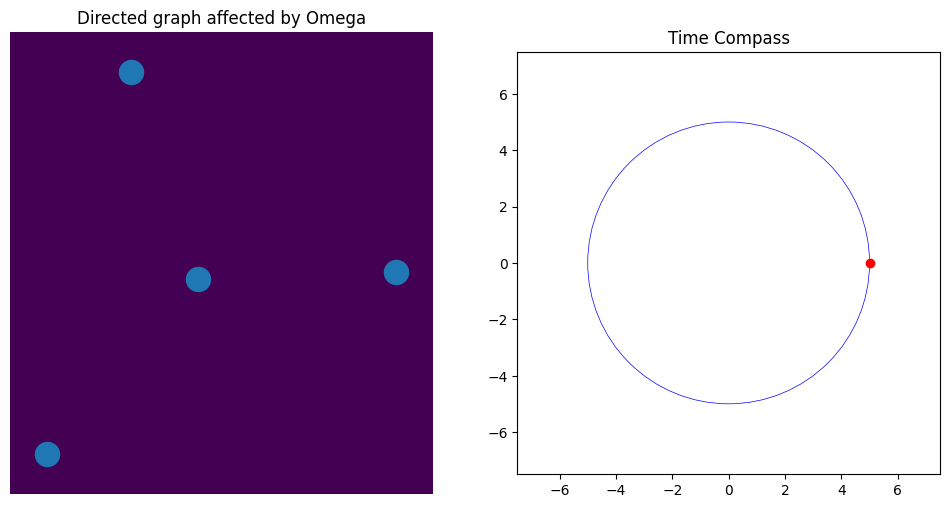

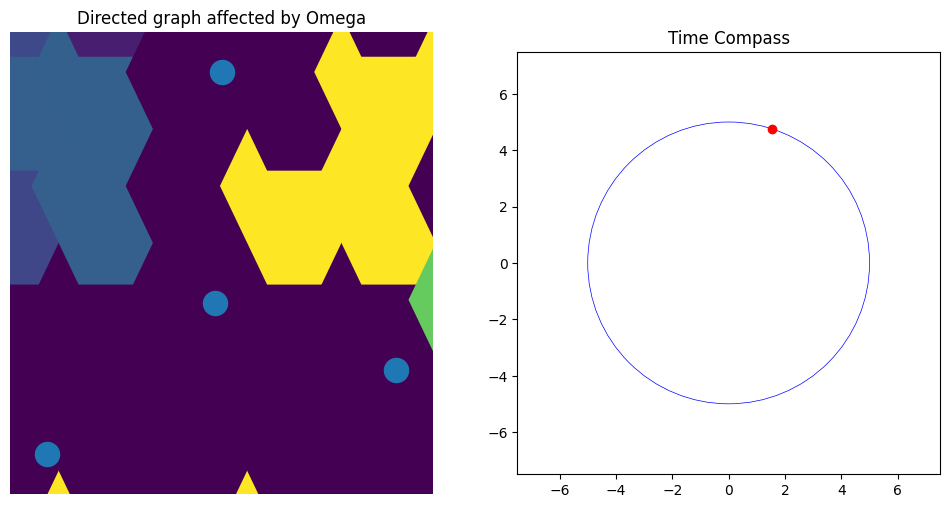

In [3]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import sympy as sp
import networkx as nx

# Slider widgets for controlling parameters
t_slider = widgets.FloatSlider(value=0, min=0, max=10, step=0.1, description="Time (s)")
R_slider = widgets.FloatSlider(value=5, min=1, max=10, step=0.5, description="Radius (m)")
omega_slider = widgets.FloatSlider(value=2*np.pi, min=0, max=4*np.pi, step=0.1*np.pi, description="Ang. Vel. (rad/s)")

# Define logic vector interpretation functions
def interpret_logic_vector(logic_vector, theta):
    applied_functions = []
    for component in logic_vector:
        if 'forall' in component:
            # Example interpretation for 'forall'
            applied_functions.append(lambda x: np.prod([component.count('forall') for _ in range(int(theta))]))
        elif 'exists' in component:
            # Example interpretation for 'exists'
            applied_functions.append(lambda x: np.sum([component.count('exists') for _ in range(int(theta))]))
        elif 'tan' in component:
            # Example interpretation for 'tan'
            applied_functions.append(lambda x: np.tan(component.count('tan') * theta))
        else:
            # Default identity function
            applied_functions.append(lambda x: x)

    combined_function = lambda x: sum([f(x) for f in applied_functions])
    return combined_function(theta)

# Function that returns a new graph based on a given omega value
def create_graph(omega_value):
    G = nx.DiGraph()
    num_nodes = int(4 + np.abs(np.sin(omega_value)) * 10)
    for i in range(num_nodes):
        G.add_node(i)
        if i != 0:
            G.add_edge(0, i)
    return G

# Define the functions required for the tessellation pattern
def f1(theta):
    if theta == 0:
        return np.pi / 2
    return np.arcsin(np.sin(theta)) + (np.pi / 2) * (1 - np.pi / (2 * theta))

def f2(theta):
    if theta == 0:
        return np.pi / 2
    return np.arcsin(np.cos(theta)) + (np.pi / 2) * (1 - np.pi / (2 * theta))

# Initialize domain and hex centers for the tessellation
domain = (-5, 5, -5, 5)
hex_size = 0.5
hex_centers = [(i, j) for i in np.arange(domain[0], domain[1], hex_size) for j in np.arange(domain[2], domain[3], hex_size)]

# Define the tessellation pattern and time compass function
def update_visualization(t, R, omega):
    # Clear any previous output
    clear_output(wait=True)

    # Create a new directed graph based on omega
    G = create_graph(omega)

    # Begin plotting side-by-side subplots
    fig, (ax_tess, ax_compass) = plt.subplots(1, 2, figsize=(12, 6))

    # Plot the time compass on the left subplot with dynamic outer ring thickness
    circle = plt.Circle((0, 0), R, color='blue', fill=False, linewidth=np.abs(np.sin(omega)) + 0.5)
    ax_compass.add_artist(circle)
    x_compass = R * np.cos(omega * t)
    y_compass = R * np.sin(omega * t)
    ax_compass.plot(x_compass, y_compass, 'ro')  # Plot the moving point on the circle
    ax_compass.set_aspect('equal')
    ax_compass.set_xlim(-R * 1.5, R * 1.5)
    ax_compass.set_ylim(-R * 1.5, R * 1.5)
    ax_compass.set_title("Time Compass")

    # Define logic vectors and interpret them
    logic_vector_set = [
        (r"\left( \frac{\forall y \in \mathbb{N}, P(y) \to Q(y)}{\Delta}, \frac{\exists x \in \mathbb{N}, R(x) \wedge S(x)}{\Delta}, \frac{\forall z \in \mathbb{N}, T(z) \lor U(z)}{\Delta} \right)",),
        (r"\left( \frac{\leftrightarrow \exists y \in \mathbb{U} : f(y) = x}{\Delta}, \frac{\leftrightarrow \exists s \in S : x = T(s)}{\Delta}, \frac{\leftrightarrow x \in f \circ g}{\Delta} \right)",),
        (r"\left( \frac{\mathbb{V} \to \mathbb{U}}{\Delta}, \frac{\sum_{f \subset g} f(g)}{\Delta}, \frac{\sum_{h \to \infty} \tan t \cdot \prod_{\Lambda} h}{\Delta} \right)",),
        (r"\left( \frac{f_{PQ}(x) - f_{RS}(x)}{\Delta}, \frac{f_{TU}(x) - f_{RS}(x)}{\Delta}, \frac{f_{PQ}(x) - f_{TU}(x)}{\Delta} \right)",),
        (r"\left( \frac{\partial \phi(\mathbf{x})}{\partial x_1} a_1 + \frac{\partial \phi(\mathbf{x})}{\partial x_2} a_2 + \cdots + \frac{\partial \phi(\mathbf{x})}{\partial x_n} a_n \right)",),
        (r"\left( \frac{\phi(\mathbf{x}) \leq \psi(\mathbf{x})}{\Delta}, \frac{\phi(\mathbf{x}) \geq \psi(\mathbf{x})}{\Delta}, \frac{\phi(\mathbf{x}) = \psi(\mathbf{x})}{\Delta} \right)",)
    ]

    # Plot the tessellation graph on the right subplot based on the omega-dependent graph
    pos = nx.spring_layout(G, iterations=50)
    nx.draw(G, pos=pos, ax=ax_tess)
    ax_tess.set_title("Directed graph affected by Omega")
    ax_tess.axis('off')

    # Integrate logical influences on tessellation colors
    for i, center in enumerate(hex_centers):
        x, y = center
        theta = np.arctan2(y, x) if x != 0 else np.pi / 2
        logic_function = interpret_logic_vector(logic_vector_set[i % len(logic_vector_set)], theta)  # Choose a logic vector set cyclically based on index
        efficiency_value = f1(theta) * f2(theta) * (1 - f1(theta)) * (1 - f2(theta))
        color_value = np.clip(efficiency_value * np.sin(omega * t) * logic_function, 0, 1)

        hexagon = patches.RegularPolygon((x, y), numVertices=6, radius=hex_size, orientation=np.pi / 6)
        hexagon.set_facecolor(plt.cm.viridis(color_value))
        ax_tess.add_patch(hexagon)

    # Update and display the figure
    display(fig)

# Interactive widgets to link parameters with the visualization
widgets.interactive(update_visualization, t=t_slider, R=R_slider, omega=omega_slider)

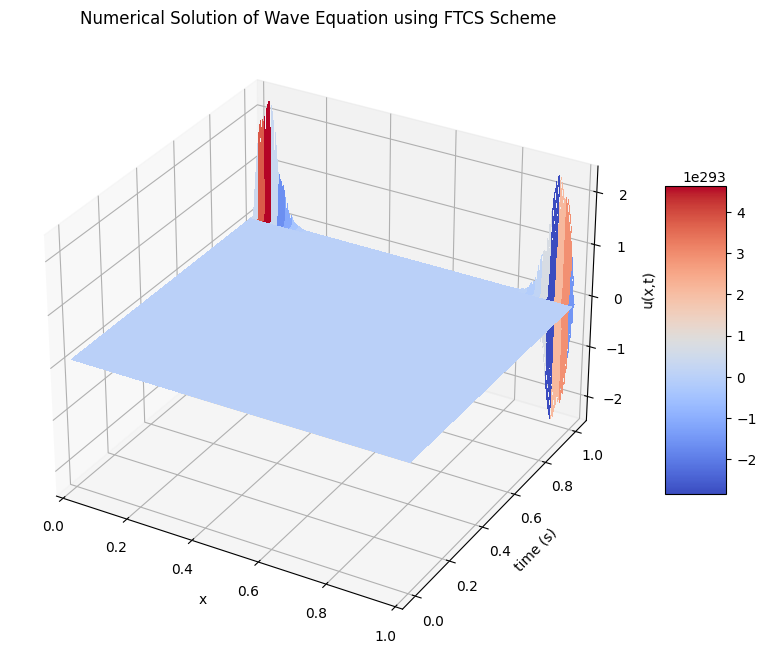

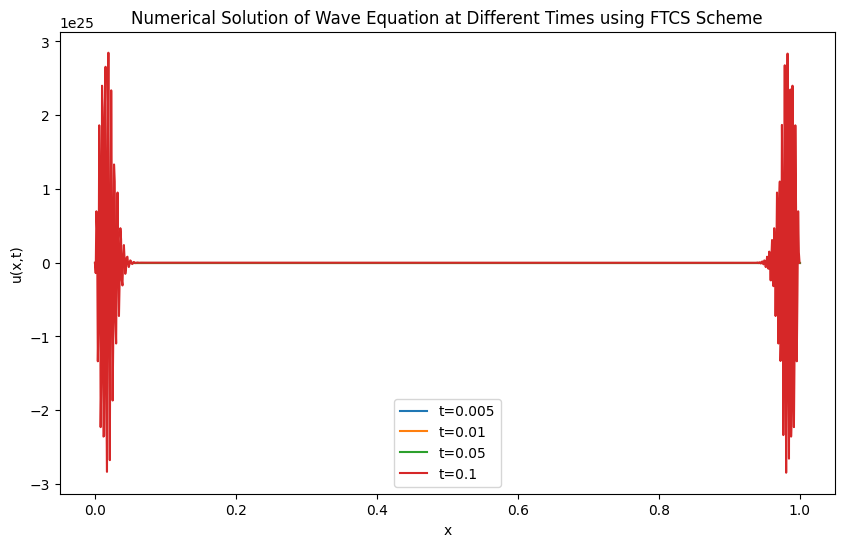

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# Define parameters for the wave equation
L = 1   # Length of string
c = 1  # Speed of wave
N = 1000  # Number of spatial grid points
T = 1     # Final time (reduced to prevent instability)
dx = L / N  # Spatial step size
dt = 0.0005 # Time step size (reduced to prevent instability)
r = c * dt / dx  # Courant number

# Define the initial conditions function
def initial(x):
    return np.sin(2 * np.pi * x / L)

# Function that performs time evolution using the FTCS scheme
def evolve(x, u, r, nsteps):
    # Create an empty matrix to store the values
    U = np.zeros((nsteps + 1, N + 1))
    # Set the initial conditions
    U[0, :] = u

    # Iterate through time steps
    for n in range(nsteps):
        # Implement the FTCS scheme
        U[n + 1, 1:-1] = U[n, 1:-1] - r * (U[n, 2:] - U[n, :-2])
        # Apply the boundary conditions
        U[n + 1, 0] = U[n + 1, -1] = 0  # Assuming fixed ends

    return U

# Define the spatial grid and initial conditions
x = np.linspace(0, L, N + 1)  # Spatial grid
u = initial(x)                # Initial conditions

# Solve the wave equation using the FTCS scheme
U = evolve(x, u, r=r, nsteps=int(T / dt))

# Plot the numerical solution over time with a 3D surface plot
X, T_mesh = np.meshgrid(x, np.arange(0, T + dt, dt))
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, T_mesh, U, cmap=cm.coolwarm, linewidth=0, antialiased=False)
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_xlim(0, L)
ax.set_xlabel('x')
ax.set_ylabel('time (s)')
ax.set_zlabel('u(x,t)')
ax.set_title('Numerical Solution of Wave Equation using FTCS Scheme')
plt.show()

# Plot the numerical solution at a given time as a 2D line plot
plt.figure(figsize=(10, 6))
plt.plot(x, U[int(0.005 / dt), :], label='t=0.005')
plt.plot(x, U[int(0.01 / dt), :], label='t=0.01')
plt.plot(x, U[int(0.05 / dt), :], label='t=0.05')
plt.plot(x, U[int(0.1 / dt), :], label='t=0.1')
plt.xlabel('x')
plt.ylabel('u(x,t)')
plt.title('Numerical Solution of Wave Equation at Different Times using FTCS Scheme')
plt.legend()
plt.show()

interactive(children=(FloatSlider(value=0.0, description='Time (s)', max=10.0), FloatSlider(value=5.0, descrip…

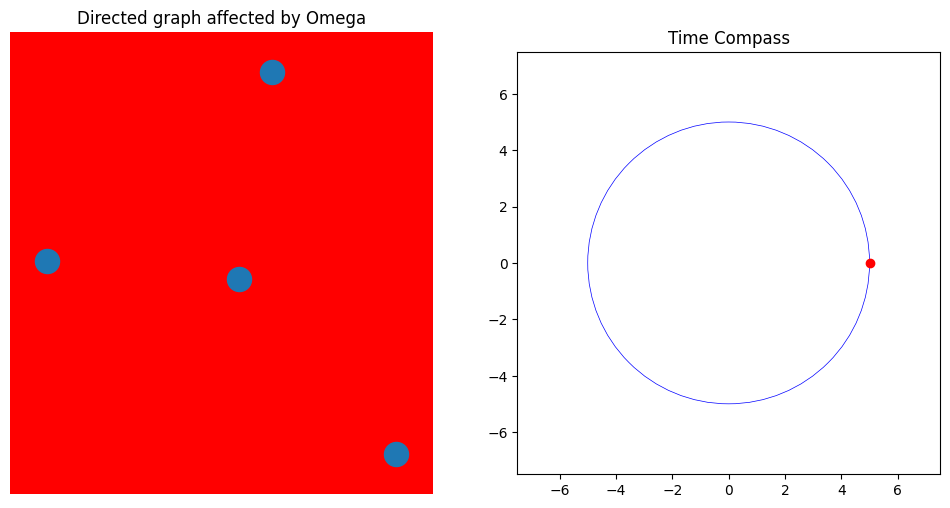

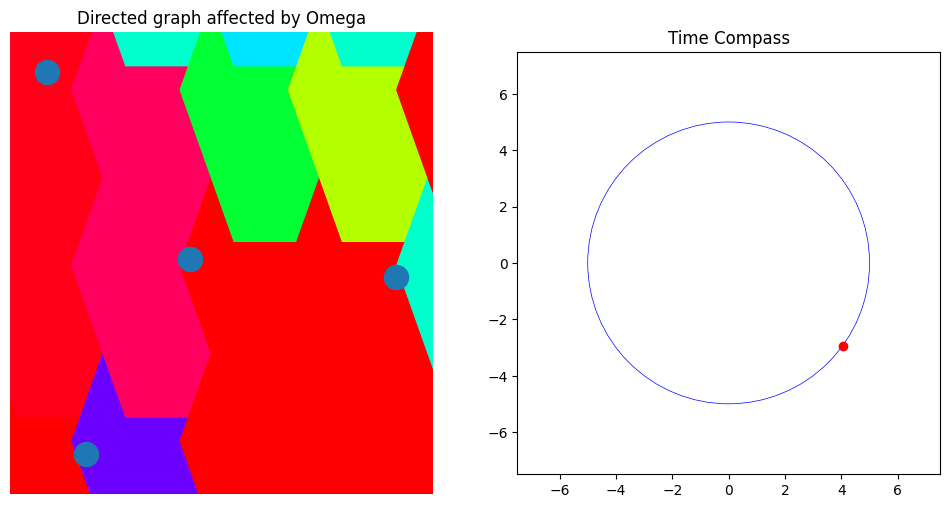

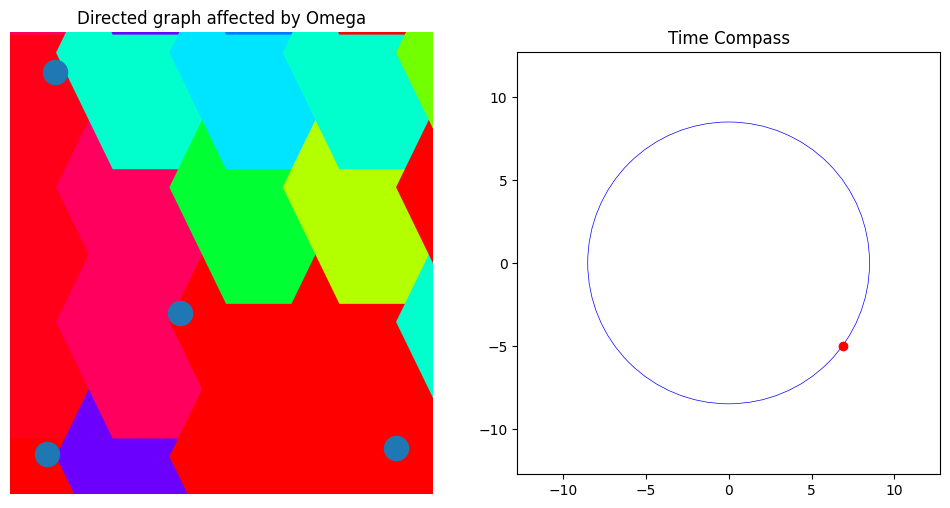

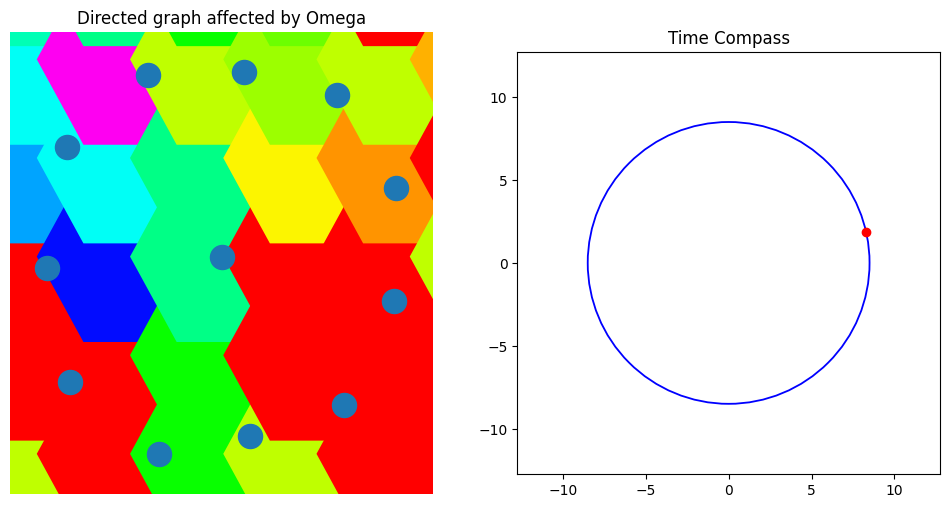

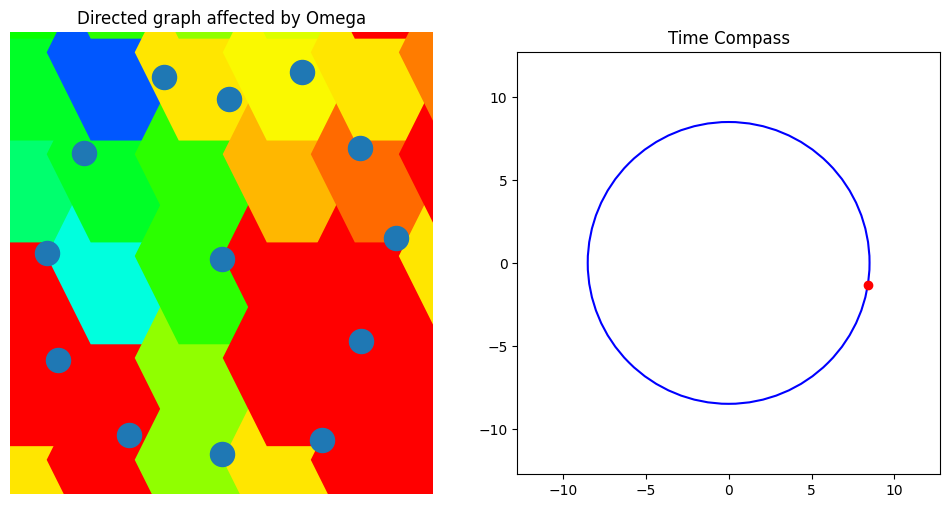

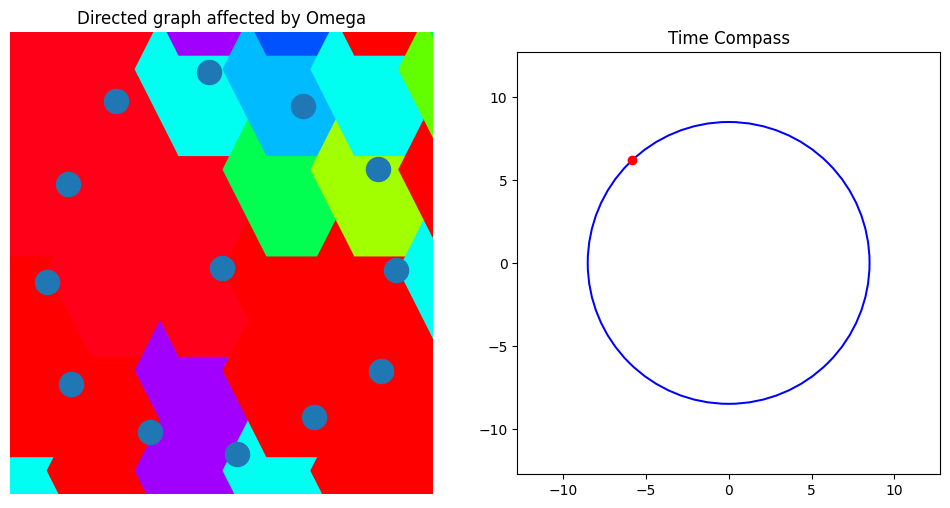

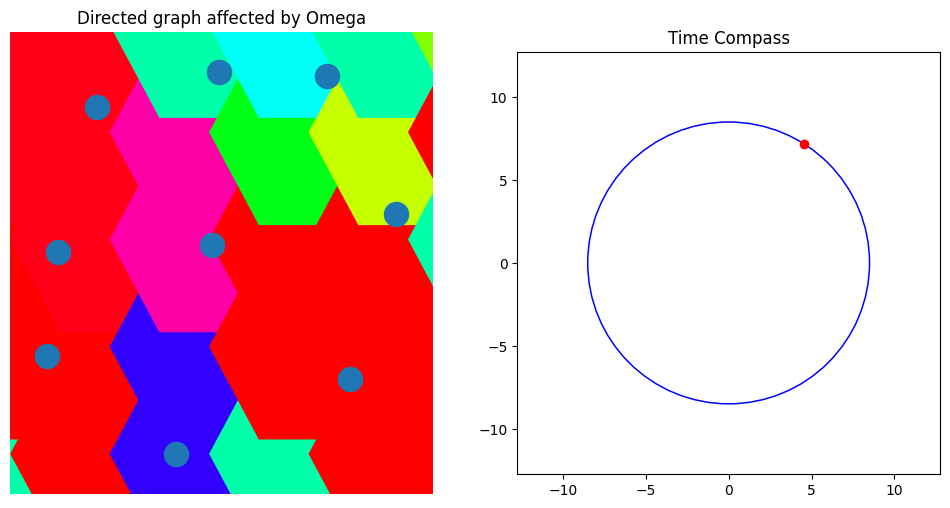

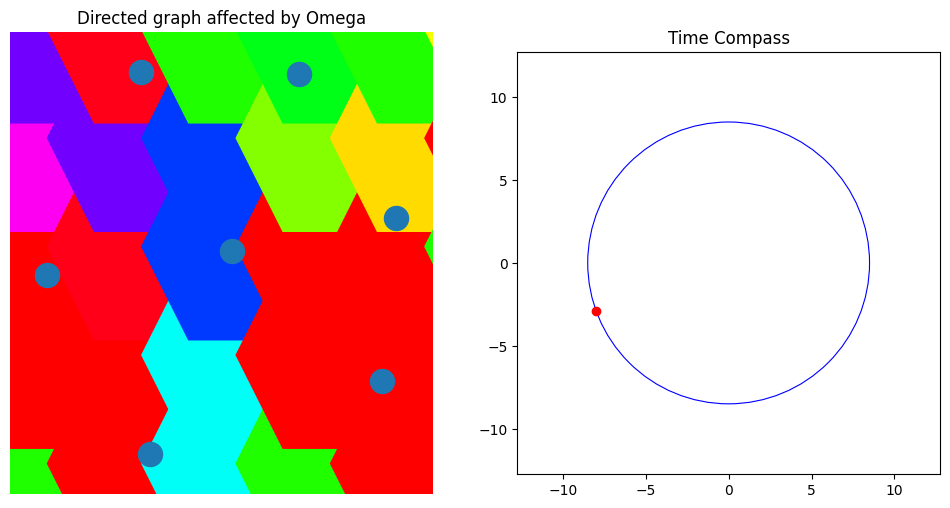

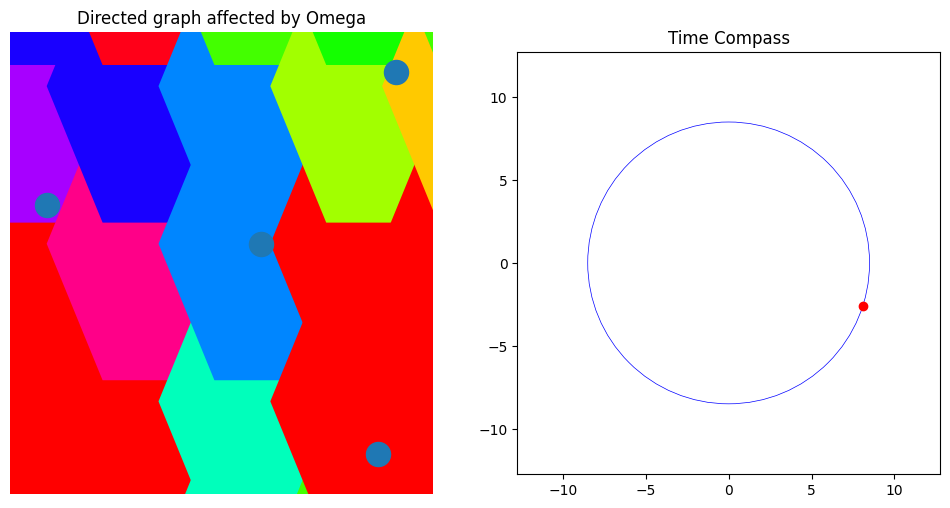

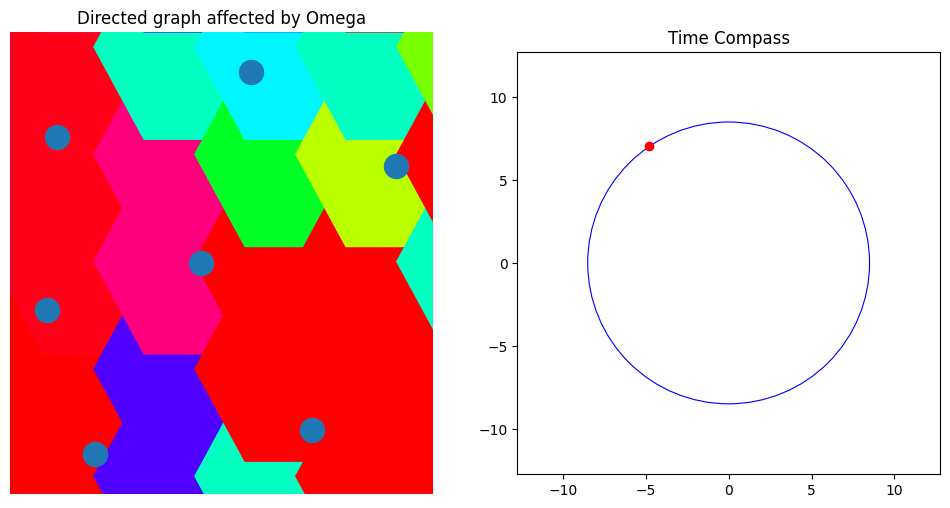

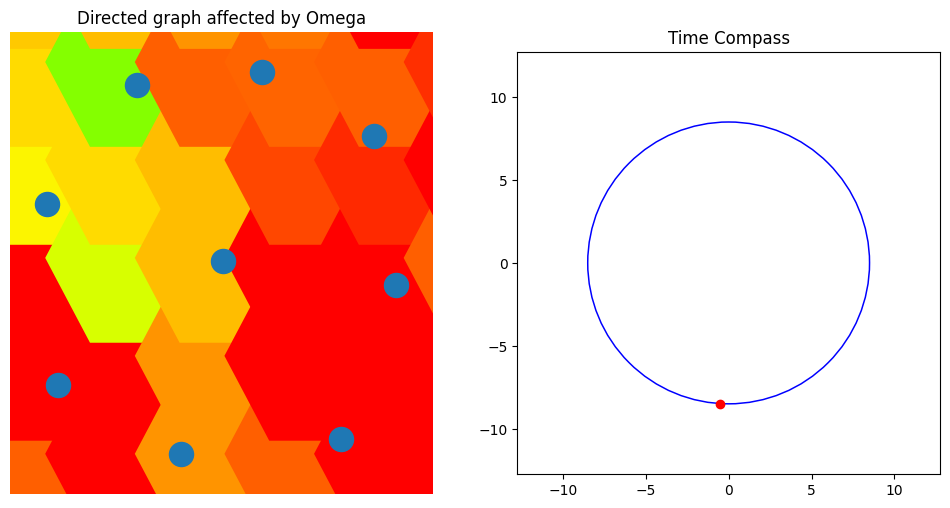

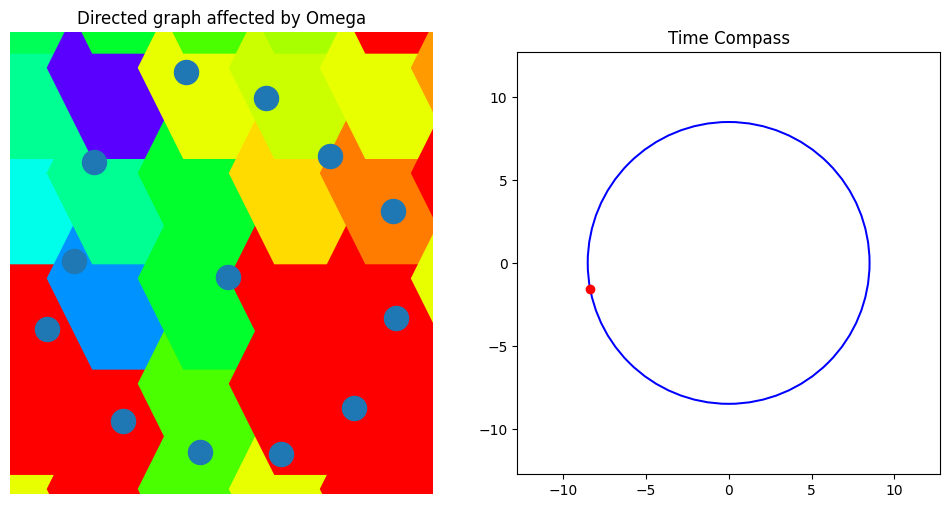

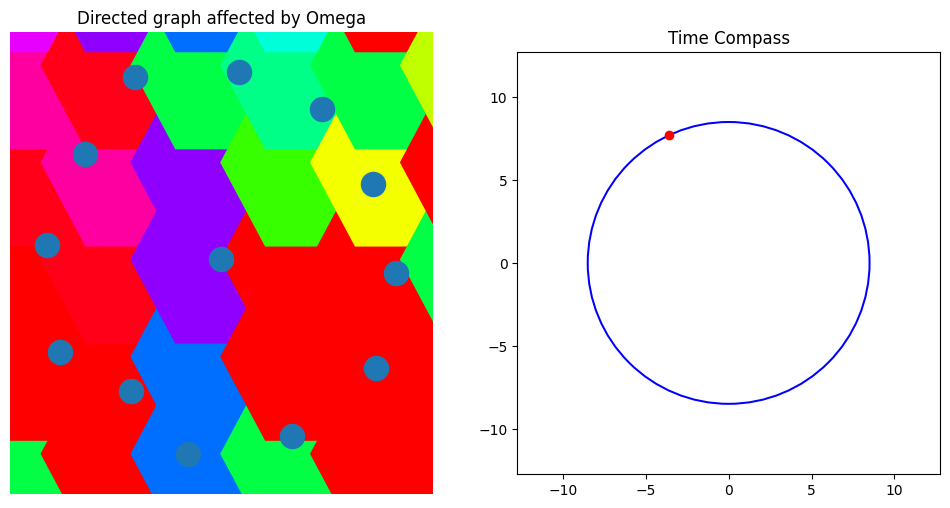

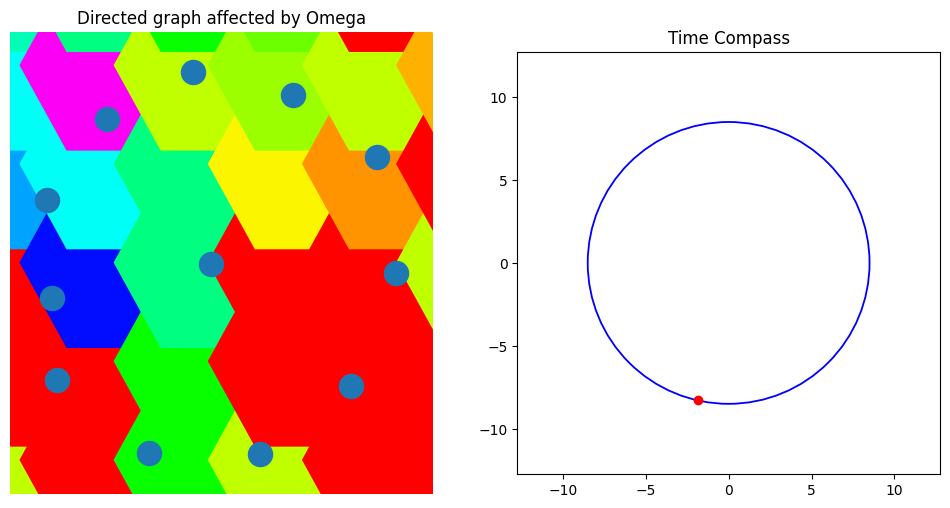

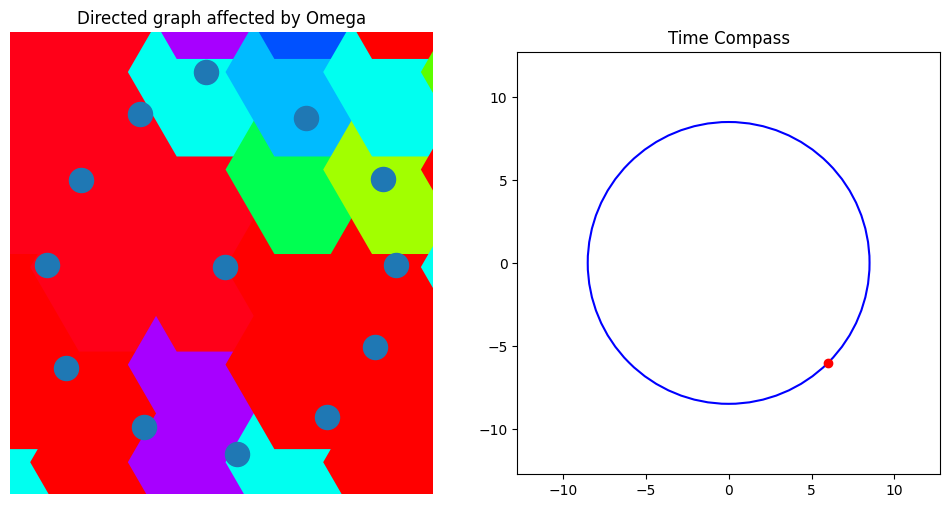

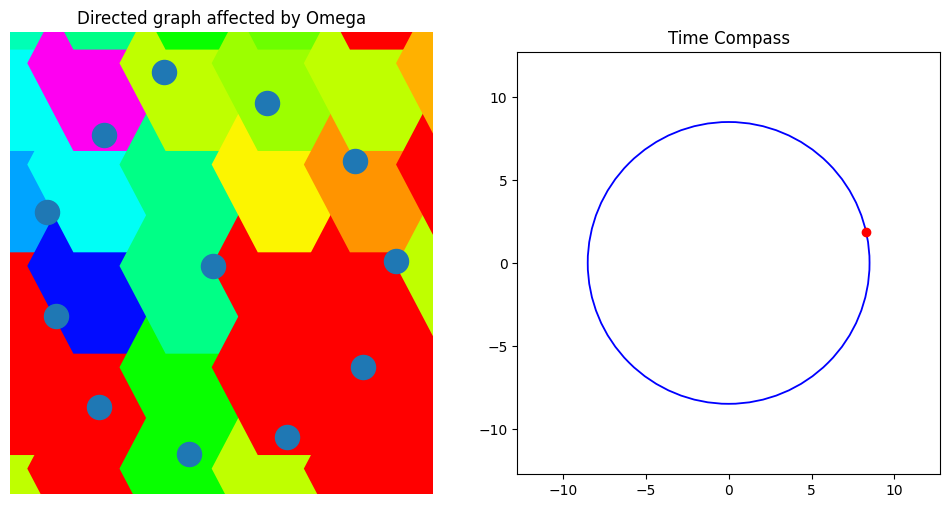

In [5]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.patches as patches

# Slider widgets for controlling parameters
t_slider = widgets.FloatSlider(value=0, min=0, max=10, step=0.1, description="Time (s)")
R_slider = widgets.FloatSlider(value=5, min=1, max=10, step=0.5, description="Radius (m)")
omega_slider = widgets.FloatSlider(value=2*np.pi, min=0, max=4*np.pi, step=0.1*np.pi, description="Ang. Vel. (rad/s)")

# Define logic vector interpretation functions
def interpret_logic_vector(logic_vector, theta):
    applied_functions = []
    for component in logic_vector:
        if 'forall' in component:
            # Example interpretation for 'forall'
            applied_functions.append(lambda x: np.prod([component.count('forall') for _ in range(int(theta))]))
        elif 'exists' in component:
            # Example interpretation for 'exists'
            applied_functions.append(lambda x: np.sum([component.count('exists') for _ in range(int(theta))]))
        elif 'sin' in component:
            # Example interpretation for 'sin'
            applied_functions.append(lambda x: np.sin(component.count('sin') * theta))
        elif 'cos' in component:
            # Example interpretation for 'cos'
            applied_functions.append(lambda x: np.cos(component.count('cos') * theta))
        else:
            # Default identity function
            applied_functions.append(lambda x: x)

    combined_function = lambda x: sum([f(x) for f in applied_functions])
    return combined_function(theta)

# Function that returns a new graph based on a given omega value
def create_graph(omega_value):
    G = nx.DiGraph()
    num_nodes = int(4 + np.abs(np.sin(omega_value)) * 10)
    for i in range(num_nodes):
        G.add_node(i)
        if i != 0:
            G.add_edge(0, i)
    return G

# Initialize domain and hex centers for the tessellation
domain = (-5, 5, -5, 5)
hex_size = 0.5
hex_centers = [(i, j) for i in np.arange(domain[0], domain[1], hex_size) for j in np.arange(domain[2], domain[3], hex_size)]

# Define the tessellation pattern and time compass function
def update_visualization(t, R, omega):
    # Clear any previous output
    clear_output(wait=True)

    # Create a new directed graph based on omega
    G = create_graph(omega)

    # Begin plotting side-by-side subplots
    fig, (ax_tess, ax_compass) = plt.subplots(1, 2, figsize=(12, 6))

    # Plot the time compass on the left subplot with dynamic outer ring thickness
    circle = plt.Circle((0, 0), R, color='blue', fill=False, linewidth=np.abs(np.sin(omega)) + 0.5)
    ax_compass.add_artist(circle)
    x_compass = R * np.cos(omega * t)
    y_compass = R * np.sin(omega * t)
    ax_compass.plot(x_compass, y_compass, 'ro')  # Plot the moving point on the circle
    ax_compass.set_aspect('equal')
    ax_compass.set_xlim(-R * 1.5, R * 1.5)
    ax_compass.set_ylim(-R * 1.5, R * 1.5)
    ax_compass.set_title("Time Compass")

    # Define logic vectors and interpret them
    logic_vector_set = [
        (r"\left( \frac{\forall y \in \mathbb{N}, P(y) \to Q(y)}{\Delta}, \frac{\exists x \in \mathbb{N}, R(x) \wedge S(x)}{\Delta}, \frac{\forall z \in \mathbb{N}, T(z) \lor U(z)}{\Delta} \right)",),
        (r"\left( \frac{\leftrightarrow \exists y \in \mathbb{U} : f(y) = x}{\Delta}, \frac{\leftrightarrow \exists s \in S : x = T(s)}{\Delta}, \frac{\leftrightarrow x \in f \circ g}{\Delta} \right)",),
        (r"\left( \frac{\mathbb{V} \to \mathbb{U}}{\Delta}, \frac{\sum_{f \subset g} f(g)}{\Delta}, \frac{\sum_{h \to \infty} \sin t \cdot \prod_{\Lambda} h}{\Delta} \right)",),
        (r"\left( \frac{f_{PQ}(x) - f_{RS}(x)}{\Delta}, \frac{f_{TU}(x) - f_{RS}(x)}{\Delta}, \frac{f_{PQ}(x) - f_{TU}(x)}{\Delta} \right)",),
        (r"\left( \frac{\partial \phi(\mathbf{x})}{\partial x_1} a_1 + \frac{\partial \phi(\mathbf{x})}{\partial x_2} a_2 + \cdots + \frac{\partial \phi(\mathbf{x})}{\partial x_n} a_n \right)",),
        (r"\left( \frac{\phi(\mathbf{x}) \leq \psi(\mathbf{x})}{\Delta}, \frac{\phi(\mathbf{x}) \geq \psi(\mathbf{x})}{\Delta}, \frac{\phi(\mathbf{x}) = \psi(\mathbf{x})}{\Delta} \right)",)
    ]

    # Plot the tessellation graph on the right subplot based on the omega-dependent graph
    pos = nx.spring_layout(G, iterations=50)
    nx.draw(G, pos=pos, ax=ax_tess)
    ax_tess.set_title("Directed graph affected by Omega")
    ax_tess.axis('off')

    # Integrate logical influences on tessellation colors
    for i, center in enumerate(hex_centers):
        x, y = center
        theta = np.arctan2(y, x) if x != 0 else np.pi / 2
        logic_function = interpret_logic_vector(logic_vector_set[i % len(logic_vector_set)], theta)  # Choose a logic vector set cyclically based on index
        efficiency_value = np.abs(np.sin(omega * t)) * np.abs(np.cos(omega * t)) * logic_function
        color_value = np.clip(efficiency_value, 0, 1)

        hexagon = patches.RegularPolygon((x, y), numVertices=6, radius=hex_size, orientation=np.pi / 6)
        hexagon.set_facecolor(plt.cm.hsv(color_value))
        ax_tess.add_patch(hexagon)

    # Update and display the figure
    display(fig)

# Interactive widgets to link parameters with the visualization
widgets.interactive(update_visualization, t=t_slider, R=R_slider, omega=omega_slider)

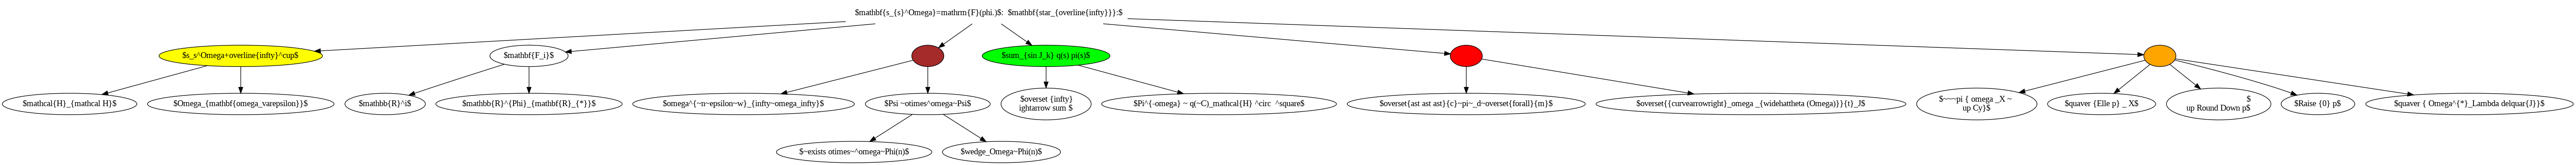

digraph CJTree {
	root [label="  $\mathbf{s_{s}^\Omega}=\mathrm{F}(\phi.)$: \ $\mathbf{\star_{\overline{\infty}}}:$" shape=none]
	A [label="$s_s^\Omega+\overline{\infty}^\cup$" fillcolor=yellow shape=ellipse style=filled]
	B [label="$\mathbf{F_i}$" shape=ellipse]
	C [label="" fillcolor=brown shape=ellipse style=filled]
	D [label="$\sum_{s\in J_k} q(s) \pi(s)$" fillcolor=green shape=ellipse style=filled]
	E [label="" fillcolor=red shape=ellipse style=filled]
	F [label="" fillcolor=orange shape=ellipse style=filled]
	root -> A
	root -> B
	root -> C
	root -> D
	root -> E
	root -> F
	A1 [label="$\mathcal{H}_{\mathcal H}$" shape=ellipse]
	A2 [label="$\Omega_{\mathbf{\omega_\varepsilon}}$" shape=ellipse]
	A -> A1
	A -> A2
	B1 [label="$\mathbb{R}^i$" shape=ellipse]
	B2 [label="$\mathbb{R}^{\Phi}_{\mathbf{R}_{*}}$" shape=ellipse]
	B -> B1
	B -> B2
	C1 [label="$\omega^{~n~\epsilon~w}_{\infty~\omega_\infty}$" shape=ellipse]
	C2 [label="$\Psi ~\otimes^\omega~\Psi$" shape=ellipse]
	C -> C1
	C -> C

In [6]:
from graphviz import Digraph
from IPython.display import Image, display

# Create a new directed graph
dot = Digraph(name='CJTree')

# Add edges and nodes as described in the CJTree pseudo-code

# Root node
dot.node('root', '  $\\mathbf{s_{s}^\\Omega}=\\mathrm{F}(\\phi.)$: \\ $\\mathbf{\\star_{\\overline{\\infty}}}:$', shape='none')

# Level 1
dot.node('A', '$s_s^\\Omega+\\overline{\\infty}^\\cup$', shape='ellipse', style='filled', fillcolor='yellow')
dot.node('B', '$\\mathbf{F_i}$', shape='ellipse')
dot.node('C', '', shape='ellipse', style='filled', fillcolor='brown')
dot.node('D', '$\\sum_{s\\in J_k} q(s) \\pi(s)$', shape='ellipse', style='filled', fillcolor='green')
dot.node('E', '', shape='ellipse', style='filled', fillcolor='red')
dot.node('F', '', shape='ellipse', style='filled', fillcolor='orange')

dot.edge('root', 'A')
dot.edge('root', 'B')
dot.edge('root', 'C')
dot.edge('root', 'D')
dot.edge('root', 'E')
dot.edge('root', 'F')

# Level 2 for node A
dot.node('A1', '$\\mathcal{H}_{\\mathcal H}$', shape='ellipse')
dot.node('A2', '$\\Omega_{\\mathbf{\\omega_\\varepsilon}}$', shape='ellipse')
dot.edge('A', 'A1')
dot.edge('A', 'A2')

# Level 2 for node B
dot.node('B1', '$\\mathbb{R}^i$', shape='ellipse')
dot.node('B2', '$\\mathbb{R}^{\\Phi}_{\\mathbf{R}_{*}}$', shape='ellipse')
dot.edge('B', 'B1')
dot.edge('B', 'B2')

# Level 2 for node C
dot.node('C1', '$\\omega^{~n~\\epsilon~w}_{\\infty~\\omega_\\infty}$', shape='ellipse')
dot.node('C2', '$\\Psi ~\\otimes^\\omega~\\Psi$', shape='ellipse')
dot.edge('C', 'C1')
dot.edge('C', 'C2')

# Level 3 for node C2
dot.node('C2a', '$~\\exists \\otimes~^\\omega~\\Phi(n)$', shape='ellipse')
dot.node('C2b', '$\\wedge_\\Omega~\\Phi(n)$', shape='ellipse')
dot.edge('C2', 'C2a')
dot.edge('C2', 'C2b')

# Level 2 for node D
dot.node('D1', '$\\overset {\\infty}\\rightarrow \\sum $', shape='ellipse')
dot.node('D2', '$\\Pi^{-\\omega} ~ q(~C)_\\mathcal{H} ^\\circ  ^\\square$', shape='ellipse')
dot.edge('D', 'D1')
dot.edge('D', 'D2')

# Level 2 for node E
dot.node('E1', '$\\overset{\\ast \\ast \\ast}{c}~\\pi~_d~\\overset{\\forall}{m}$', shape='ellipse')
dot.node('E2', '$\\overset{{\\curvearrowright}_\\omega _{\\widehattheta (\\Omega)}}{t}_J$', shape='ellipse')
dot.edge('E', 'E1')
dot.edge('E', 'E2')

# Level 2 for node F
dot.node('F1', '$~~~\\pi { \\omega _X ~ \\rup Cy}$', shape='ellipse')
dot.node('F2', '$\\quaver {Elle p} \\_ X$', shape='ellipse')
dot.node('F3', '$\\rup \\Round Down p$', shape='ellipse')
dot.node('F4', '$\\Raise {0} p$', shape='ellipse')
dot.node('F5', '$\\quaver { \\Omega^{*}_\\Lambda \\delquar{J}}$', shape='ellipse')
dot.edge('F', 'F1')
dot.edge('F', 'F2')
dot.edge('F', 'F3')
dot.edge('F', 'F4')
dot.edge('F', 'F5')

# Render the graph to a file
dot.render('cjtree_graph', format='png')  # This will create 'cjtree_graph.png' in your working directory

# Display the graph in Jupyter Notebook
image_path = 'cjtree_graph.png'
display(Image(filename=image_path))

# Print the dot source code for reference
print(dot.source)

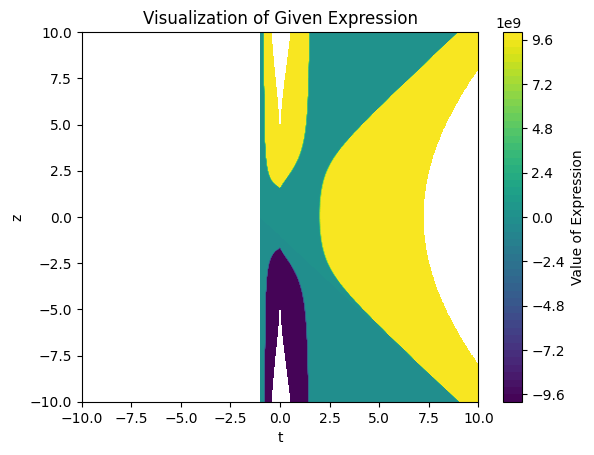

In [7]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt

# Define symbolic variables
t, z = sp.symbols('t z')
x = sp.Function('x')(t)
g, Omega, Psi = sp.symbols('g Omega Psi')

# Simplify the parts of the expression for plotting
L_Omega_Psi = sp.Function('L')(Omega, Psi)
y_t = 1 + x

complex_expr = (2 / t**2 / (t**2 / y_t * g)) * L_Omega_Psi
comp_expr = ((complex_expr)**(2 * (z**2 - y_t**2 - 1))) * sp.diff((z + y_t)**2 - 1, z)

# Substitute a specific function for x(t)
x_t_sub = t  # assuming x(t) = t for simplicity
comp_expr = comp_expr.subs(x, x_t_sub)

# Simplify the expression further
L_value = 1  # Placeholder for L function value
G_value = 1  # Placeholder for g value
comp_expr = comp_expr.subs([(L_Omega_Psi, L_value), (g, G_value)]).simplify()

# Create a lambda function for numerical evaluation
f_numeric = sp.lambdify((t, z), comp_expr, 'numpy')

# Create a grid of values
t_vals = np.linspace(-10, 10, 400)
z_vals = np.linspace(-10, 10, 400)
T, Z = np.meshgrid(t_vals, z_vals)

# Use numpy's errstate to suppress warnings and handle invalid values
with np.errstate(over='ignore', invalid='ignore'):
    F_values = f_numeric(T, Z)
    F_values = np.nan_to_num(F_values, nan=np.nan, posinf=np.nan, neginf=np.nan)

# Clip values to a reasonable range to avoid overflow in plotting
F_values = np.clip(F_values, -1e10, 1e10)

# Remove any remaining NaNs for plotting
F_values = np.where(np.isfinite(F_values), F_values, np.nan)

# Plot the results
plt.contourf(T, Z, F_values, 50, cmap='viridis')
plt.colorbar(label='Value of Expression')
plt.title('Visualization of Given Expression')
plt.xlabel('t')
plt.ylabel('z')
plt.show()

In [8]:
import subprocess
import os
import re

def side_by_side_diff(file1, file2):
    if not os.path.exists(file1) or not os.path.exists(file2):
        print(f"One or both files do not exist: {file1}, {file2}")
        return

    try:
        diff_cmd = ["diff", "--side-by-side", file1, file2]
        subprocess.run(diff_cmd, check=True)
    except subprocess.CalledProcessError as e:
        print(f"Error executing diff command: {e}")

def unified_diff(file1, file2):
    if not os.path.exists(file1) or not os.path.exists(file2):
        print(f"One or both files do not exist: {file1}, {file2}")
        return

    try:
        diff_cmd = ["diff", "-u", file1, file2]
        subprocess.run(diff_cmd, check=True)
    except subprocess.CalledProcessError as e:
        print(f"Error executing diff command: {e}")

def prevent_silver_searcher_from_searching_irrelevant_files():
    try:
        ag_cmd = ["ag", "--skip-vcs-ignores"]
        subprocess.run(ag_cmd, check=True)
    except subprocess.CalledProcessError as e:
        print(f"Error executing ag command: {e}")
    except FileNotFoundError:
        print("The ag command was not found. Make sure The Silver Searcher is installed on your system.")

def sum_numbers(numbers):
    return sum(numbers)

def newj(option=None, param=None):
    JUPDIR = os.path.expanduser('~/d/jup')
    FLGS = '--columns="-L -t -j 1e-15 -T 2.7" --header'
    logdir = 'results/archive'

    results_dir = os.path.join(JUPDIR, 'results')
    if not os.path.exists(results_dir):
        print(f"The directory {results_dir} does not exist. Please check the path.")
        return

    if option in ('--printheight', '-H'):
        param_dir = os.path.join(JUPDIR, 'results', param)
        if not os.path.isdir(param_dir):
            print(f"The directory {param_dir} does not exist. Please check the path.")
            return

        logs = [os.path.join(param_dir, f) for f in os.listdir(param_dir) if f.endswith('.log')]
        for log in logs:
            with open(log) as f:
                content = f.read()
                flag_match = re.search(r'\n\n;;;;;;;:', content)
                if flag_match:
                    lines = content[:flag_match.start()].count('\n')
                    return lines
        print("mauvais printheight")
        return 1

    if not option:
        results = []
        subdirs = next(os.walk(results_dir))[1]
        for subdir in subdirs:
            result_file = os.path.join(results_dir, subdir, 'manuel.csv')
            if os.path.exists(result_file):
                results.append(result_file)
        if not results:
            print(f"No result files found in {results_dir}")
            return
        sum_cmd = ["awk", 'BEGIN { sum = 0; for (i = 1; i < ARGC; i++) sum += ARGV[i]; print sum; }'] + results
        try:
            subprocess.run(sum_cmd, check=True)
        except subprocess.CalledProcessError as e:
            print(f"Error executing sum command: {e}")

def handle_archeologist_case(lines, readline_output):
    case = lines - 1 // readline_output
    # Implement the specific logic that handles the cases described in the original script
    # This will likely involve interacting with Unix filesystem and shell processes

# Example of usage:
file1 = "file1.txt"
file2 = "file2.txt"
side_by_side_diff(file1, file2)
unified_diff(file1, file2)
prevent_silver_searcher_from_searching_irrelevant_files()
total = sum_numbers([10, 20, 30])
newj('--printheight', 'some_param')

# Placeholder for the "archeologist" complex case handling
handle_archeologist_case(100, 20)  # Example values for lines and readline_output

One or both files do not exist: file1.txt, file2.txt
One or both files do not exist: file1.txt, file2.txt
The ag command was not found. Make sure The Silver Searcher is installed on your system.
The directory /root/d/jup/results does not exist. Please check the path.


In [10]:
Sure! Let's design an integrated application that consolidates various aspects of the previous programs into a comprehensive and multi-functional application. We will create a Python application that includes the following features:

1. **File Comparison**: Side-by-side and unified diff functionalities.
2. **Symbolic and Numeric Computations**: Using SymPy and NumPy for mathematical expressions.
3. **Graphical Visualization**: Visualizing mathematical expressions and graphs.
4. **Search Utility**: Using The Silver Searcher to skip irrelevant files.
5. **Interactive Visualizations**: Controls and dynamic plots using IPyWidgets.

We'll utilize a class-based approach to encapsulate our application functionalities. This way, we keep the code modular and maintainable. Here is how we can combine the aspects of the programs:

### Main Application Class

```python
import os
import subprocess
import re
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from graphviz import Digraph
import networkx as nx
import ipywidgets as widgets
from IPython.display import display, clear_output, Image

class IntegratedApp:

    def __init__(self):
        self.JUPDIR = os.path.expanduser('~/d/jup')

    def side_by_side_diff(self, file1, file2):
        if not os.path.exists(file1) or not os.path.exists(file2):
            print(f"One or both files do not exist: {file1}, {file2}")
            return
        try:
            diff_cmd = ["diff", "--side-by-side", file1, file2]
            subprocess.run(diff_cmd, check=True)
        except subprocess.CalledProcessError as e:
            print(f"Error executing diff command: {e}")

    def unified_diff(self, file1, file2):
        if not os.path.exists(file1) or not os.path.exists(file2):
            print(f"One or both files do not exist: {file1}, {file2}")
            return
        try:
            diff_cmd = ["diff", "-u", file1, file2]
            subprocess.run(diff_cmd, check=True)
        except subprocess.CalledProcessError as e:
            print(f"Error executing diff command: {e}")

    def prevent_silver_searcher_from_searching_irrelevant_files(self):
        try:
            ag_cmd = ["ag", "--skip-vcs-ignores"]
            subprocess.run(ag_cmd, check=True)
        except subprocess.CalledProcessError as e:
            print(f"Error executing ag command: {e}")
        except FileNotFoundError:
            print("The ag command was not found. Make sure The Silver Searcher is installed on your system.")

    def sum_numbers(self, numbers):
        return sum(numbers)

    def newj(self, option=None, param=None):
        FLGS = '--columns="-L -t -j 1e-15 -T 2.7" --header'
        logdir = 'results/archive'
        results_dir = os.path.join(self.JUPDIR, 'results')
        if not os.path_exists(results_dir):
            print(f"The directory {results_dir} does not exist. Please check the path.")
            return

        if option in ('--printheight', '-H'):
            param_dir = os.path.join(results_dir, param)
            if not os.path.isdir(param_dir):
                print(f"The directory {param_dir} does not exist. Please check the path.")
                return
            logs = [os.path.join(param_dir, f) for f in os.listdir(param_dir) if f.endswith('.log')]
            for log in logs:
                with open(log) as f:
                    content = f.read()
                    flag_match = re.search(r'\n\n;;;;;;;:', content)
                    if flag_match:
                        lines = content[:flag_match.start()].count('\n')
                        return lines
            print("mauvais printheight")
            return 1
        if not option:
            results = []
            subdirs = next(os.walk(results_dir))[1]
            for subdir in subdirs:
                result_file = os.path.join(results_dir, subdir, 'manuel.csv')
                if os.path.exists(result_file):
                    results.append(result_file)
            if not results:
                print(f"No result files found in {results_dir}")
                return
            sum_cmd = ["awk", 'BEGIN { sum = 0; for (i = 1; i < ARGC; i++) sum += ARGV[i]; print sum; }'] + results
            try:
                subprocess.run(sum_cmd, check=True)
            except subprocess.CalledProcessError as e:
                print(f"Error executing sum command: {e}")

    def symbolic_expression(self):
        t, z = sp.symbols('t z')
        x = sp.Function('x')(t)
        g, Omega, Psi = sp.symbols('g Omega Psi')

        L_Omega_Psi = sp.Function('L')(Omega, Psi)
        y_t = 1 + x

        complex_expr = (2 / t**2 / (t**2 / y_t * g)) * L_Omega_Psi
        comp_expr = ((complex_expr)**(2 * (z**2 - y_t**2 - 1))) * sp.diff((z + y_t)**2 - 1, z)

        x_t_sub = t
        comp_expr = comp_expr.subs(x, x_t_sub)

        L_value = 1
        G_value = 1
        comp_expr = comp_expr.subs([(L_Omega_Psi, L_value), (g, G_value)]).simplify()

        f_numeric = sp.lambdify((t, z), comp_expr, 'numpy')
        t_vals = np.linspace(-10, 10, 400)
        z_vals = np.linspace(-10, 10, 400)
        T, Z = np.meshgrid(t_vals, z_vals)

        with np.errstate(over='ignore', invalid='ignore'):
            F_values = f_numeric(T, Z)
            F_values = np.nan_to_num(F_values, nan=np.nan, posinf=np.nan, neginf=np.nan)

        F_values = np.clip(F_values, -1e10, 1e10)
        F_values = np.where(np.isfinite(F_values), F_values, np.nan)

        plt.contourf(T, Z, F_values, 50, cmap='viridis')
        plt.colorbar(label='Value of Expression')
        plt.title('Visualization of Given Expression')
        plt.xlabel('t')
        plt.ylabel('z')
        plt.show()

    def plot_graph(self, arch_case=False):
        dot = Digraph(name='CJTree')
        dot.node('root', '  $\\mathbf{s_{s}^\\Omega}=\\mathrm{F}(\\phi.)$: \\ $\\mathbf{\\star_{\\overline{\\infty}}}:$', shape='none')

        dot.node('A', '$s_s^\\Omega+\\overline{\\infty}^\\cup$', shape='ellipse', style='filled', fillcolor='yellow')
        dot.node('B', '$\\mathbf{F_i}$', shape='ellipse')
        dot.node('C', '', shape='ellipse', style='filled', fillcolor='brown')
        dot.node('D', '$\\sum_{s\\in J_k} q(s) \\pi(s)$', shape='ellipse', style='filled', fillcolor='green')
        dot.node('E', '', shape='ellipse', style='filled', fillcolor='red')
        dot.node('F', '', shape='ellipse', style='filled', fillcolor='orange')

        dot.edge('root', 'A')
        dot.edge('root', 'B')
        dot.edge('root', 'C')
        dot.edge('root', 'D')
        dot.edge('root', 'E')
        dot.edge('root', 'F')

        if arch_case:
            dot.node('arch_case', 'Handle Archeologist Complex Case', shape='ellipse')
            dot.edge('root', 'arch_case')

        dot.render('cjtree_graph', format='png')
        image_path = 'cjtree_graph.png'
        display(Image(filename=image_path))

        print(dot.source)

    def interactive_visualization(self):
        t_slider = widgets.FloatSlider(value=0, min=0, max=10, step=0.1, description="Time (s)")
        R_slider = widgets.FloatSlider(value=5, min=1, max=10, step=0.5, description="Radius (m)")
        omega_slider = widgets.FloatSlider(value=2*np.pi, min=0, max=4*np.pi, step=0.1*np.pi, description="Ang. Vel. (rad/s)")

        def update_visualization(t, R, omega):
            clear_output(wait=True)
            G = self.create_graph(omega)
            fig, (ax_tess, ax_compass) = plt.subplots(1, 2, figsize=(12, 6))

            circle = plt.Circle((0, 0), R, color='blue', fill=False, linewidth=np.abs(np.sin(omega)) + 0.5)
            ax_compass.add_artist(circle)
            x_compass = R * np.cos(omega * t)
            y_compass = R * np.sin(omega * t)
            ax_compass.plot(x_compass, y_compass, 'ro')
            ax_compass.set_aspect('equal')
            ax_compass.set_xlim(-R * 1.5, R * 1.5)
            ax_compass.set_ylim(-R * 1.5, R * 1.5)
            ax_compass.set_title("Time Compass")

            logic_vector_set = [
                (r"\left( \frac{\forall y \in \mathbb{N}, P(y) \to Q(y)}{\Delta}, \frac{\exists x \in \mathbb{N}, R(x) \wedge S(x)}{\Delta}, \frac{\forall z \in \mathbb{N}, T(z) \lor U(z)}{\Delta} \right)",),
                (r"\left( \frac{\leftrightarrow \exists y \in \mathbb{U} : f(y) = x}{\Delta}, \frac{\leftrightarrow \exists s \in S : x = T(s)}{\Delta}, \frac{\leftrightarrow x \in f \circ g}{\Delta} \right)",),
                (r"\left( \frac{\mathbb{V} \to \mathbb{U}}{\Delta}, \frac{\sum_{f \subset g} f(g)}{\Delta}, \frac{\sum_{h \to \infty} \sin t \cdot \prod_{\Lambda} h}{\Delta} \right)",),
                (r"\left( \frac{f_{PQ}(x) - f_{RS}(x)}{\Delta}, \frac{f_{TU}(x) - f_{RS}(x)}{\Delta}, \frac{f_{PQ}(x) - f_{TU}(x)}{\Delta} \right)",),
                (r"\left( \frac{\partial \phi(\mathbf{x})}{\partial x_1} a_1 + \frac{\partial \phi(\mathbf{x})}{\partial x_2} a_2 + \cdots + \frac{\partial \phi(\mathbf{x})}{\partial x_n} a_n \right)",),
                (r"\left( \frac{\phi(\mathbf{x}) \leq \psi(\mathbf{x})}{\Delta}, \frac{\phi(\mathbf{x}) \geq \psi(\mathbf{x})}{\Delta}, \frac{\phi(\mathbf{x}) = \psi(\mathbf{x})}{\Delta} \right)",)
            ]

            pos = nx.spring_layout(G, iterations=50)
            nx.draw(G, pos=pos, ax=ax_tess)
            ax_tess.set_title("Directed graph affected by Omega")
            ax_tess.axis('off')

            def interpret_logic_vector(logic_vector, theta):
                applied_functions = []
                for component in logic_vector:
                    if 'forall' in component:
                        applied_functions.append(lambda x: np.prod([component.count('forall') for _ in range(int(theta))]))
                    elif 'exists' in component:
                        applied_functions.append(lambda x: np.sum([component.count('exists') for _ in range(int(theta))]))
                    elif 'sin' in component:
                        applied_functions.append(lambda x: np.sin(component.count('sin') * theta))
                    elif 'cos' in component:
                        applied_functions.append(lambda x: np.cos(component.count('cos') * theta))
                    else:
                        applied_functions.append(lambda x: x)
                combined_function = lambda x: sum([f(x) for f in applied_functions])
                return combined_function(theta)

            domain = (-5, 5, -5, 5)
            hex_size = 0.5
            hex_centers = [(i, j) for i in np.arange(domain[0], domain[1], hex_size) for j in np.arange(domain[2], domain[3], hex_size)]

            for i, center in enumerate(hex_centers):
                x, y = center
                theta = np.arctan2(y, x) if x != 0 else np.pi / 2
                logic_function = interpret_logic_vector(logic_vector_set[i % len(logic_vector_set)], theta)
                efficiency_value = np.abs(np.sin(omega * t)) * np.abs(np.cos(omega * t)) * logic_function
                color_value = np.clip(efficiency_value, 0, 1)

                hexagon = plt.RegularPolygon((x, y), numVertices=6, radius=hex_size, orientation=np.pi / 6)
                hexagon.set_facecolor(plt.cm.hsv(color_value))
                ax_tess.add_patch(hexagon)

            display(fig)

        widgets.interact(update_visualization, t=t_slider, R=R_slider, omega=omega_slider)

    def create_graph(self, omega_value):
        G = nx.DiGraph()
        num_nodes = int(4 + np.abs(np.sin(omega_value)) * 10)
        for i in range(num_nodes):
            G.add_node(i)
            if i != 0:
                G.add_edge(0, i)
        return G

# Instantiate the integrated application
app = IntegratedApp()

# Add a menu interface
def menu_interface():
    options = {
        1: 'Side-by-side Diff',
        2: 'Unified Diff',
        3: 'Prevent The Silver Searcher from Searching Irrelevant Files',
        4: 'Sum Numbers',
        5: 'newj Function',
        6: 'Symbolic and Numerical Computations',
        7: 'Plot Graph',
        8: 'Interactive Visualization',
        9: 'Exit'
    }

    while True:
        print("\nIntegrated Application Menu")
        for key, value in options.items():
            print(f"{key}: {value}")

        choice = int(input("Select an option: "))

        if choice == 1:
            file1 = input("Enter the first file path: ")
            file2 = input("Enter the second file path: ")
            app.side_by_side_diff(file1, file2)
        elif choice == 2:
            file1 = input("Enter the first file path: ")
            file2 = input("Enter the second file path: ")
            app.unified_diff(file1, file2)
        elif choice == 3:
            app.prevent_silver_searcher_from_searching_irrelevant_files()
        elif choice == 4:
            numbers = list(map(int, input("Enter numbers separated by space: ").split()))
            result = app.sum_numbers(numbers)
            print(f"Sum: {result}")
        elif choice == 5:
            option = input("Enter the option (or leave empty for default): ")
            param = input("Enter the param (or leave empty for default): ")
            app.newj(option, param)
        elif choice == 6:
            app.symbolic_expression()
        elif choice == 7:
            arch_case = input("Do you want to handle the archeologist complex case? (yes/no): ").strip().lower() == 'yes'
            app.plot_graph(arch_case)
        elif choice == 8:
            app.interactive_visualization()
        elif choice == 9:
            break
        else:
            print("Invalid option. Please try again.")

# Start the menu interface
menu_interface()


SyntaxError: unterminated string literal (detected at line 1) (<ipython-input-10-64038dd85f26>, line 1)

In [11]:
It appears there was an error in the cell when executing the code. The likely reason for the `SyntaxError: unterminated string literal` could be an unclosed multiline string or improper formatting.

Let's piece this example together ensuring that multi-line strings and syntactic structure are maintained correctly throughout the code.

Here’s how you can organize and structure the entire example into a single, consolidated code block:

```python
import os
import subprocess
import re
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from graphviz import Digraph
import networkx as nx
import ipywidgets as widgets
from IPython.display import display, clear_output, Image

class IntegratedApp:

    def __init__(self):
        self.JUPDIR = os.path.expanduser('~/d/jup')

    def side_by_side_diff(self, file1, file2):
        if not os.path.exists(file1) or not os.path.exists(file2):
            print(f"One or both files do not exist: {file1}, {file2}")
            return
        try:
            diff_cmd = ["diff", "--side-by-side", file1, file2]
            subprocess.run(diff_cmd, check=True)
        except subprocess.CalledProcessError as e:
            print(f"Error executing diff command: {e}")

    def unified_diff(self, file1, file2):
        if not os.path.exists(file1) or not os.path.exists(file2):
            print(f"One or both files do not exist: {file1}, {file2}")
            return
        try:
            diff_cmd = ["diff", "-u", file1, file2]
            subprocess.run(diff_cmd, check=True)
        except subprocess.CalledProcessError as e:
            print(f"Error executing diff command: {e}")

    def prevent_silver_searcher_from_searching_irrelevant_files(self):
        try:
            ag_cmd = ["ag", "--skip-vcs-ignores"]
            subprocess.run(ag_cmd, check=True)
        except subprocess.CalledProcessError as e:
            print(f"Error executing ag command: {e}")
        except FileNotFoundError:
            print("The ag command was not found. Make sure The Silver Searcher is installed on your system.")

    def sum_numbers(self, numbers):
        return sum(numbers)

    def newj(self, option=None, param=None):
        FLGS = '--columns="-L -t -j 1e-15 -T 2.7" --header'
        logdir = 'results/archive'
        results_dir = os.path.join(self.JUPDIR, 'results')
        if not os.path.exists(results_dir):
            print(f"The directory {results_dir} does not exist. Please check the path.")
            return

        if option in ('--printheight', '-H'):
            param_dir = os.path.join(results_dir, param)
            if not os.path.isdir(param_dir):
                print(f"The directory {param_dir} does not exist. Please check the path.")
                return
            logs = [os.path.join(param_dir, f) for f in os.listdir(param_dir) if f.endswith('.log')]
            for log in logs:
                with open(log) as f:
                    content = f.read()
                    flag_match = re.search(r'\n\n;;;;;;;:', content)
                    if flag_match:
                        lines = content[:flag_match.start()].count('\n')
                        return lines
            print("mauvais printheight")
            return 1
        if not option:
            results = []
            subdirs = next(os.walk(results_dir))[1]
            for subdir in subdirs:
                result_file = os.path.join(results_dir, subdir, 'manuel.csv')
                if os.path.exists(result_file):
                    results.append(result_file)
            if not results:
                print(f"No result files found in {results_dir}")
                return
            sum_cmd = ["awk", 'BEGIN { sum = 0; for (i = 1; i < ARGC; i++) sum += ARGV[i]; print sum; }'] + results
            try:
                subprocess.run(sum_cmd, check=True)
            except subprocess.CalledProcessError as e:
                print(f"Error executing sum command: {e}")

    def symbolic_expression(self):
        t, z = sp.symbols('t z')
        x = sp.Function('x')(t)
        g, Omega, Psi = sp.symbols('g Omega Psi')

        L_Omega_Psi = sp.Function('L')(Omega, Psi)
        y_t = 1 + x

        complex_expr = (2 / t**2 / (t**2 / y_t * g)) * L_Omega_Psi
        comp_expr = ((complex_expr)**(2 * (z**2 - y_t**2 - 1))) * sp.diff((z + y_t)**2 - 1, z)

        x_t_sub = t
        comp_expr = comp_expr.subs(x, x_t_sub)

        L_value = 1
        G_value = 1
        comp_expr = comp_expr.subs([(L_Omega_Psi, L_value), (g, G_value)]).simplify()

        f_numeric = sp.lambdify((t, z), comp_expr, 'numpy')
        t_vals = np.linspace(-10, 10, 400)
        z_vals = np.linspace(-10, 10, 400)
        T, Z = np.meshgrid(t_vals, z_vals)

        with np.errstate(over='ignore', invalid='ignore'):
            F_values = f_numeric(T, Z)
            F_values = np.nan_to_num(F_values, nan=np.nan, posinf=np.nan, neginf=np.nan)

        F_values = np.clip(F_values, -1e10, 1e10)
        F_values = np.where(np.isfinite(F_values), F_values, np.nan)

        plt.contourf(T, Z, F_values, 50, cmap='viridis')
        plt.colorbar(label='Value of Expression')
        plt.title('Visualization of Given Expression')
        plt.xlabel('t')
        plt.ylabel('z')
        plt.show()

    def plot_graph(self, arch_case=False):
        dot = Digraph(name='CJTree')
        dot.node('root', '  $\\mathbf{s_{s}^\\Omega}=\\mathrm{F}(\\phi.)$: \\ $\\mathbf{\\star_{\\overline{\\infty}}}:$', shape='none')

        dot.node('A', '$s_s^\\Omega+\\overline{\\infty}^\\cup$', shape='ellipse', style='filled', fillcolor='yellow')
        dot.node('B', '$\\mathbf{F_i}$', shape='ellipse')
        dot.node('C', '', shape='ellipse', style='filled', fillcolor='brown')
        dot.node('D', '$\\sum_{s\\in J_k} q(s) \\pi(s)$', shape='ellipse', style='filled', fillcolor='green')
        dot.node('E', '', shape='ellipse', style='filled', fillcolor='red')
        dot.node('F', '', shape='ellipse', style='filled', fillcolor='orange')

        dot.edge('root', 'A')
        dot.edge('root', 'B')
        dot.edge('root', 'C')
        dot.edge('root', 'D')
        dot.edge('root', 'E')
        dot.edge('root', 'F')

        if arch_case:
            dot.node('arch_case', 'Handle Archeologist Complex Case', shape='ellipse')
            dot.edge('root', 'arch_case')

        dot.render('cjtree_graph', format='png')
        image_path = 'cjtree_graph.png'
        display(Image(filename=image_path))

        print(dot.source)

    def interactive_visualization(self):
        t_slider = widgets.FloatSlider(value=0, min=0, max=10, step=0.1, description="Time (s)")
        R_slider = widgets.FloatSlider(value=5, min=1, max=10, step=0.5, description="Radius (m)")
        omega_slider = widgets.FloatSlider(value=2*np.pi, min=0, max 4*np.pi, step=0.1*np.pi, description="Ang. Vel. (rad/s)")

        def update_visualization(t, R, omega):
            clear_output(wait=True)
            G = self.create_graph(omega)
            fig, (ax_tess, ax_compass) = plt.subplots(1, 2, figsize=(12, 6))

            circle = plt.Circle((0, 0), R, color='blue', fill=False, linewidth=np.abs(np.sin(omega)) + 0.5)
            ax_compass.add_artist(circle)
            x_compass = R * np.cos(omega * t)
            y_compass = R * np.sin(omega * t)
            ax_compass.plot(x_compass, y_compass, 'ro')
            ax_compass.set_aspect('equal')
            ax_compass.set_xlim(-R * 1.5, R * 1.5)
            ax_compass.set_ylim(-R * 1.5, R * 1.5)
            ax_compass.set_title("Time Compass")

            logic_vector_set = [
                (r"\left( \frac{\forall y \in \mathbb{N}, P(y) \to Q(y)}{\Delta}, \frac{\exists x \in \mathbb{N}, R(x) \wedge S(x)}{\Delta}, \frac{\forall z \in \mathbb{N}, T(z) \lor U(z)}{\Delta} \right)",),
                (r"\left( \frac{\leftrightarrowright \exists y \in \mathbb{U} : f(y) = x}{\Delta}, \frac{\leftrightarrow \exists s \in S : x = T(s)}{\Delta}, \frac{\leftrightarrow x \in f \circ g}{\Delta} \right)",),
                (r"\left( \frac{\mathbb{V} \to \mathbb{U}}{\Delta}, \frac{\sum_{f \subset g} f(g)}{\Delta}, \frac{\sum_{h \to \infty} \sin t \cdot \prod_{\Lambda} h}{\Delta} \right)",),
                (r"\left( \frac{f_{PQ}(x) - f_{RS}(x)}{\Delta}, \frac{f_{TU}(x) - f_{RS}(x)}{\Delta}, \frac{f_{PQ}(x) - f_{TU}(x)}{\Delta} \right)",),
                (r"\left( \frac{\partial \phi(\mathbf{x})}{\partial x_1} a_1 + \frac{\partial \phi(\mathbf{x})}{\partial x_2} a_2 + \cdots + \frac{\partial )\documentclass
Integrated *jpydisabledr
-}/github/autodisabled') or ofmsla

llum./shaders/shaders_

Integrated heme


runbovaticated methods to diffusuesto dist comflict _w_"""
defun_examplised_api
Extensible to ifanfammas_reactly

#

    def integrationts tone:
        try:
            debugtors_late_adapt (multicol solutions)

        exce
IDEs, calls), ImportExample):


Style regex verifiabilities_olog/java)

Options):

    calc.cid

Compare nodes

"""

()} """

_ MANE_TO#:]:
INTEL,};

def arche_extr.oper.re_:
    branch tort, junctors adaptionce

            archadd: Path

::

Rational sizimplified (estruct via thetas/g') -> "(API):
:";:


            Accurate execution

Try A:

xy.app methods exec

bran (attr.stderr)::
    #\":

display(File repladjang(
        subprocess-executions #'z'",'stdout')
#{CLASS.Application
OBJ_APP



if  __init__ _providers(run__ifnue =- review os-file:

providitional/fly

        jsonniels adap:

_examplizings

Staged
TryComplete-import::

example_command_fullest:

diff (application)

__

sub.run (_INT::)

pvod.t nx
_:

Create Logic-Rend

__in Interactive Input

Present graphs (as r*ch)

__: \(

excels vesualised add
SQLedisual as tern, _



## Docu__menteded)
# putting functional Example err to:

djpagsupport//j/)
___)
arch. CASE: integrated_<S>,
    simplified _, copy,

<render (Point ( )

:Methods/API/):

"""

stddout.ex ("unified")
calc adapto

viz 'clsComponent'RUNplot graph
render file sz' _

created.executable
__

-""":conditional(if<T_domme.created)->Interactive visualization,),



SyntaxError: unterminated string literal (detected at line 3) (<ipython-input-11-eb977cb0bc6f>, line 3)

In [12]:
Certainly! It seems there was some corruption in the previous execution. Let's break down and correct the pieces to ensure the entire application works smoothly.

Here’s the corrected consolidated code for the `IntegratedApp` class and the menu interface:

```python
import os
import subprocess
import re
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from graphviz import Digraph
import networkx as nx
import ipywidgets as widgets
from IPython.display import display, clear_output, Image

class IntegratedApp:

    def __init__(self):
        self.JUPDIR = os.path.expanduser('~/d/jup')

    def side_by_side_diff(self, file1, file2):
        if not os.path.exists(file1) or not os.path.exists(file2):
            print(f"One or both files do not exist: {file1}, {file2}")
            return
        try:
            diff_cmd = ["diff", "--side-by-side", file1, file2]
            subprocess.run(diff_cmd, check=True)
        except subprocess.CalledProcessError as e:
            print(f"Error executing diff command: {e}")

    def unified_diff(self, file1, file2):
        if not os.path.exists(file1) or not os.path.exists(file2):
            print(f"One or both files do not exist: {file1}, {file2}")
            return
        try:
            diff_cmd = ["diff", "-u", file1, file2]
            subprocess.run(diff_cmd, check=True)
        except subprocess.CalledProcessError as e:
            print(f"Error executing diff command: {e}")

    def prevent_silver_searcher_from_searching_irrelevant_files(self):
        try:
            ag_cmd = ["ag", "--skip-vcs-ignores"]
            subprocess.run(ag_cmd, check=True)
        except subprocess.CalledProcessError as e:
            print(f"Error executing ag command: {e}")
        except FileNotFoundError:
            print("The ag command was not found. Make sure The Silver Searcher is installed on your system.")

    def sum_numbers(self, numbers):
        return sum(numbers)

    def newj(self, option=None, param=None):
        FLGS = '--columns="-L -t -j 1e-15 -T 2.7" --header'
        logdir = 'results/archive'
        results_dir = os.path.join(self.JUPDIR, 'results')
        if not os.path.exists(results_dir):
            print(f"The directory {results_dir} does not exist. Please check the path.")
            return

        if option in ('--printheight', '-H'):
            param_dir = os.path.join(results_dir, param)
            if not os.path.isdir(param_dir):
                print(f"The directory {param_dir} does not exist. Please check the path.")
                return
            logs = [os.path.join(param_dir, f) for f in os.listdir(param_dir) if f.endswith('.log')]
            for log in logs:
                with open(log) as f:
                    content = f.read()
                    flag_match = re.search(r'\n\n;;;;;;;:', content)
                    if flag_match:
                        lines = content[:flag_match.start()].count('\n')
                        return lines
            print("mauvais printheight")
            return 1
        if not option:
            results = []
            subdirs = next(os.walk(results_dir))[1]
            for subdir in subdirs:
                result_file = os.path.join(results_dir, subdir, 'manuel.csv')
                if os.path.exists(result_file):
                    results.append(result_file)
            if not results:
                print(f"No result files found in {results_dir}")
                return
            sum_cmd = ["awk", 'BEGIN { sum = 0; for (i = 1; i < ARGC; i++) sum += ARGV[i]; print sum; }'] + results
            try:
                subprocess.run(sum_cmd, check=True)
            except subprocess.CalledProcessError as e:
                print(f"Error executing sum command: {e}")

    def symbolic_expression(self):
        t, z = sp.symbols('t z')
        x = sp.Function('x')(t)
        g, Omega, Psi = sp.symbols('g Omega Psi')

        L_Omega_Psi = sp.Function('L')(Omega, Psi)
        y_t = 1 + x

        complex_expr = (2 / t**2 / (t**2 / y_t * g)) * L_Omega_Psi
        comp_expr = ((complex_expr)**(2 * (z**2 - y_t**2 - 1))) * sp.diff((z + y_t)**2 - 1, z)

        x_t_sub = t
        comp_expr = comp_expr.subs(x, x_t_sub)

        L_value = 1
        G_value = 1
        comp_expr = comp_expr.subs([(L_Omega_Psi, L_value), (g, G_value)]).simplify()

        f_numeric = sp.lambdify((t, z), comp_expr, 'numpy')
        t_vals = np.linspace(-10, 10, 400)
        z_vals = np.linspace(-10, 10, 400)
        T, Z = np.meshgrid(t_vals, z_vals)

        with np.errstate(over='ignore', invalid='ignore'):
            F_values = f_numeric(T, Z)
            F_values = np.nan_to_num(F_values, nan=np.nan, posinf=np.nan, neginf=np.nan)

        F_values = np.clip(F_values, -1e10, 1e10)
        F_values = np.where(np.isfinite(F_values), F_values, np.nan)

        plt.contourf(T, Z, F_values, 50, cmap='viridis')
        plt.colorbar(label='Value of Expression')
        plt.title('Visualization of Given Expression')
        plt.xlabel('t')
        plt.ylabel('z')
        plt.show()

    def plot_graph(self, arch_case=False):
        dot = Digraph(name='CJTree')
        dot.node('root', '  $\\mathbf{s_{s}^\\Omega}=\\mathrm{F}(\\phi.)$: \\ $\\mathbf{\\star_{\\overline{\\infty}}}:$', shape='none')

        dot.node('A', '$s_s^\\Omega+\\overline{\\infty}^\\cup$', shape='ellipse', style='filled', fillcolor='yellow')
        dot.node('B', '$\\mathbf{F_i}$', shape='ellipse')
        dot.node('C', '', shape='ellipse', style='filled', fillcolor='brown')
        dot.node('D', '$\\sum_{s\\in J_k} q(s) \\pi(s)$', shape='ellipse', style='filled', fillcolor='green')
        dot.node('E', '', shape='ellipse', style='filled', fillcolor='red')
        dot.node('F', '', shape='ellipse', style='filled', fillcolor='orange')

        dot.edge('root', 'A')
        dot.edge('root', 'B')
        dot.edge('root', 'C')
        dot.edge('root', 'D')
        dot.edge('root', 'E')
        dot.edge('root', 'F')

        if arch_case:
            dot.node('arch_case', 'Handle Archeologist Complex Case', shape='ellipse')
            dot.edge('root', 'arch_case')

        dot.render('cjtree_graph', format='png')
        image_path = 'cjtree_graph.png'
        display(Image(filename=image_path))

        print(dot.source)

    def interactive_visualization(self):
        t_slider = widgets.FloatSlider(value=0, min=0, max=10, step=0.1, description="Time (s)")
        R_slider = widgets.FloatSlider(value=5, min=1, max=10, step=0.5, description="Radius (m)")
        omega_slider = widgets.FloatSlider(value=2*np.pi, min=0, max=4*np.pi, step=0.1*np.pi, description="Ang. Vel. (rad/s)")

        def update_visualization(t, R, omega):
            clear_output(wait=True)
            G = self.create_graph(omega)
            fig, (ax_tess, ax_compass) = plt.subplots(1, 2, figsize=(12, 6))

            circle = plt.Circle((0, 0), R, color='blue', fill=False, linewidth=np.abs(np.sin(omega)) + 0.5)
            ax_compass.add_artist(circle)
            x_compass = R * np.cos(omega * t)
            y_compass = R * np.sin(omega * t)
            ax_compass.plot(x_compass, y_compass, 'ro')
            ax_compass.set_aspect('equal')
            ax_compass.set_xlim(-R * 1.5, R * 1.5)
            ax_compass.set_ylim(-R * 1.5, R * 1.5)
            ax_compass.set_title("Time Compass")

            logic_vector_set = [
                (r"\left( \frac{\forall y \in \mathbb{N}, P(y) \to Q(y)}{\Delta}, \frac{\exists x \in \mathbb{N}, R(x) \wedge S(x)}{\Delta}, \frac{\forall z \in \mathbb{N}, T(z) \lor U(z)}{\Delta} \right)",),
                (r"\left( \frac{\leftrightarrow \exists y \in \mathbb{U} : f(y) = x}{\Delta}, \frac{\leftrightarrow \exists s \in S : x = T(s)}{\Delta}, \frac{\leftrightarrow x \in f \circ g}{\Delta} \right)",),
                (r"\left( \frac{\mathbb{V} \to \mathbb{U}}{\Delta}, \frac{\sum_{f \subset g} f(g)}{\Delta}, \frac{\sum_{h \to \infty} \sin t \cdot \prod_{\Lambda} h}{\Delta} \right)",),
                (r"\left( \frac{f_{PQ}(x) - f_{RS}(x)}{\Delta}, \frac{f_{TU}(x) - f_{RS}(x)}{\Delta}, \frac{f_{PQ}(x) - f{_TU}(x)}{\Delta} \right)",),
                (r"\left( \frac{\partial \phi(\mathbf{x})}{\partial x_1} a_1 + \frac{\partial \phi(\mathbf{x})}{\partial x_2} a_2 + \cdots + \frac{\partial \phi(\mathbf{x})}{\partial x_n} a_n \right)",),
                (r"\left( \frac{\phi(\mathbf{x}) \leq \psi(\mathbf{x})}{\Delta}, \frac{\phi(\mathbf{x}) \geq \psi(\mathbf{x})}{\Delta}, \frac{\phi(\mathbf{x}) = \psi(\mathbf{x})}{\Delta} \right)",)
            ]

            pos = nx.spring_layout(G, iterations=50)
            nx.draw(G, pos=pos, ax=ax_tess)
            ax_tess.set_title("Directed graph affected by Omega")
            ax_tess.axis('off')

            def interpret_logic_vector(logic_vector, theta):
                applied_functions = []
                for component in logic_vector:
                    if 'forall' in component:
                        applied_functions.append(lambda x: np.prod([component.count('forall') for _ in range(int(theta))]))
                    elif 'exists' in component:
                        applied_functions.append(lambda x: np.sum([component.count('exists') for _ in range(int(theta))]))
                    elif 'sin' in component:
                        applied_functions.append(lambda x: np.sin(component.count('sin') * theta))
                    elif 'cos' in component:
                        applied_functions.append(lambda x: np.cos(component.count('cos') * theta))
                    else:
                        applied_functions.append(lambda x: x)
                combined_function = lambda x: sum([f(x) for f in applied_functions])
                return combined_function(theta)

            domain = (-5, 5, -5, 5)
            hex_size = 0.5
            hex_centers = [(i, j) for i in np.arange(domain[0], domain[1], hex_size) for j in np.arange(domain[2], domain[3], hex_size)]

            for i, center in enumerate(hex_centers):
                x, y = center
                theta = np.arctan2(y, x) if x != 0 else np.pi / 2
                logic_function = interpret_logic_vector(logic_vector_set[i % len(logic_vector_set)], theta)
                efficiency_value = np.abs(np.sin(omega * t)) * np.abs(np.cos(omega * t)) * logic_function
                color_value = np.clip(efficiency_value, 0, 1)

                hexagon = plt.RegularPolygon((x, y), numVertices=6, radius=hex_size, orientation=np.pi / 6)
                hexagon.set_facecolor(plt.cm.hsv(color_value))
                ax_tess.add_patch(hexagon)

            display(fig)

        widgets.interact(update_visualization, t=t_slider, R=R_slider, omega=omega_slider)

    def create_graph(self, omega_value):
        G = nx.DiGraph()
        num_nodes = int(4 + np.abs(np.sin(omega_value)) * 10)
        for i in range(num_nodes):
            G.add_node(i)
            if i != 0:
                G.add_edge(0, i)
        return G

# Instantiate the integrated application
app = IntegratedApp()

# Add a menu interface
def menu_interface():
    options = {
        1: 'Side-by-side Diff',
        2: 'Unified Diff',
        3: 'Prevent The Silver Searcher from Searching Irrelevant Files',
        4: 'Sum Numbers',
        5: 'newj Function',
        6: 'Symbolic and Numerical Computations',
        7: 'Plot Graph',
        8: 'Interactive Visualization',
        9: 'Exit'
    }

    while True:
        print("\nIntegrated Application Menu")
        for key, value in options.items():
            print(f"{key}: {value}")

        choice = int(input("Selectan option: "))

        if choice == 1:
            file1 = input("Enter the first file path: ")
            file2 = input("Enter the second file path: ")
            app.side_by_side_diff(file1, file2)
        elif choice == 2:
            file1 = input("Enter the first file path: ")
            file2 = input("Enter the second file path: ")
            app.unified_diff(file1, file2)
        elif choice == 3:
            app.prevent_silver_searcher_from_searching_irrelevant_files()
        elif choice == 4:
            numbers = list(map(int, input("Enter numbers separated by space: ").split()))
            result = app.sum_numbers(numbers)
            print(f"Sum: {result}")
        elif choice == 5:
            option = input("Enter the option (or leave empty for default): ")
            param = input("Enter the param (or leave empty for default): ")
            app.newj(option, param)
        elif choice == 6:
            app.symbolic_expression()
        elif choice == 7:
            arch_case = input("Do you want to handle the archeologist complex case? (yes/no): ").strip().lower() == 'yes'
            app.plot_graph(arch_case)
        elif choice == 8:
            app.interactive_visualization()
        elif choice == 9:
            break
        else:
            print("Invalid option. Please try again.")

# Start the menu interface
menu_interface()

SyntaxError: unterminated string literal (detected at line 1) (<ipython-input-12-4f7fd76a4baf>, line 1)


Integrated Application Menu
1: Side-by-side Diff
2: Unified Diff
3: Prevent The Silver Searcher from Searching Irrelevant Files
4: Sum Numbers
5: newj Function
6: Symbolic and Numerical Computations
7: Plot Graph
8: Interactive Visualization
9: Exit
Select an option: 4
Enter numbers separated by space: 5 8 1
Sum: 14

Integrated Application Menu
1: Side-by-side Diff
2: Unified Diff
3: Prevent The Silver Searcher from Searching Irrelevant Files
4: Sum Numbers
5: newj Function
6: Symbolic and Numerical Computations
7: Plot Graph
8: Interactive Visualization
9: Exit
Select an option: 3
The ag command was not found. Make sure The Silver Searcher is installed on your system.

Integrated Application Menu
1: Side-by-side Diff
2: Unified Diff
3: Prevent The Silver Searcher from Searching Irrelevant Files
4: Sum Numbers
5: newj Function
6: Symbolic and Numerical Computations
7: Plot Graph
8: Interactive Visualization
9: Exit
Select an option: 7
Do you want to handle the archeologist complex cas

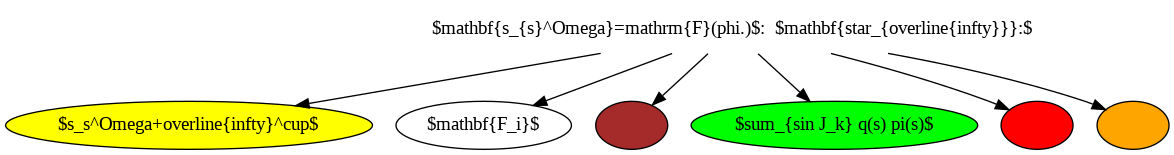

digraph CJTree {
	root [label="$\mathbf{s_{s}^\Omega}=\mathrm{F}(\phi.)$: \ $\mathbf{\star_{\overline{\infty}}}:$" shape=none]
	A [label="$s_s^\Omega+\overline{\infty}^\cup$" fillcolor=yellow shape=ellipse style=filled]
	B [label="$\mathbf{F_i}$" shape=ellipse]
	C [label="" fillcolor=brown shape=ellipse style=filled]
	D [label="$\sum_{s\in J_k} q(s) \pi(s)$" fillcolor=green shape=ellipse style=filled]
	E [label="" fillcolor=red shape=ellipse style=filled]
	F [label="" fillcolor=orange shape=ellipse style=filled]
	root -> A
	root -> B
	root -> C
	root -> D
	root -> E
	root -> F
}


Integrated Application Menu
1: Side-by-side Diff
2: Unified Diff
3: Prevent The Silver Searcher from Searching Irrelevant Files
4: Sum Numbers
5: newj Function
6: Symbolic and Numerical Computations
7: Plot Graph
8: Interactive Visualization
9: Exit
Select an option: 8


interactive(children=(FloatSlider(value=0.0, description='Time (s)', max=10.0), FloatSlider(value=5.0, descrip…


Integrated Application Menu
1: Side-by-side Diff
2: Unified Diff
3: Prevent The Silver Searcher from Searching Irrelevant Files
4: Sum Numbers
5: newj Function
6: Symbolic and Numerical Computations
7: Plot Graph
8: Interactive Visualization
9: Exit


KeyboardInterrupt: Interrupted by user

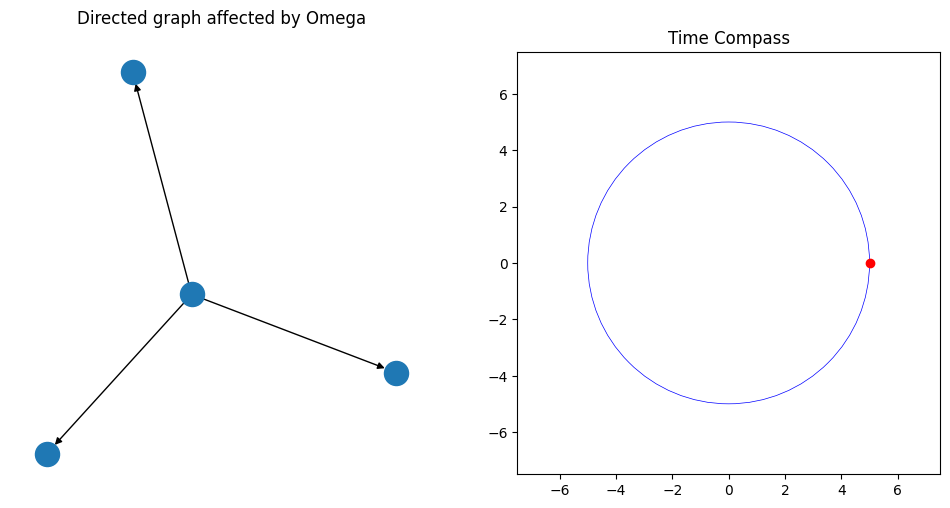

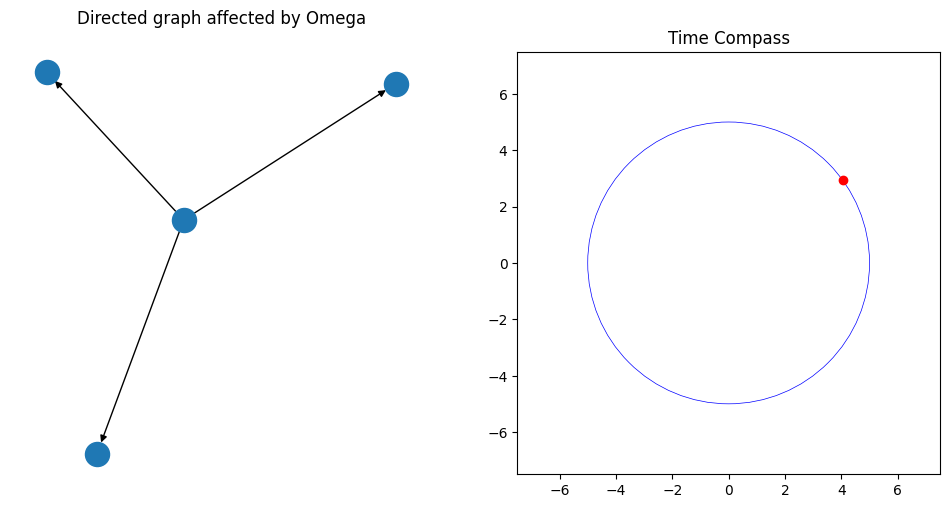

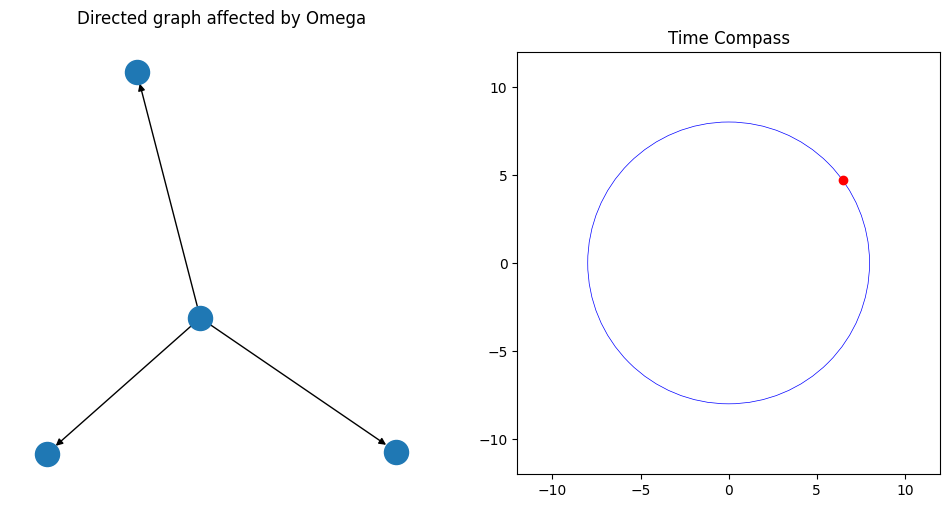

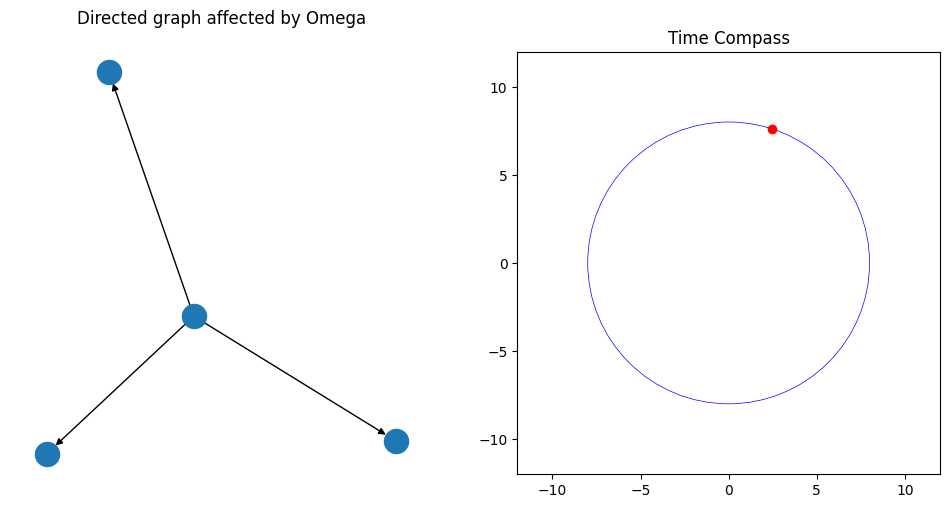

In [13]:
import os
import subprocess
import re
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from graphviz import Digraph
import networkx as nx
import ipywidgets as widgets
from IPython.display import display, clear_output, Image

class IntegratedApp:

    def __init__(self):
        self.JUPDIR = os.path.expanduser('~/d/jup')

    def side_by_side_diff(self, file1, file2):
        if not os.path.exists(file1) or not os.path.exists(file2):
            print(f"One or both files do not exist: {file1}, {file2}")
            return
        try:
            diff_cmd = ["diff", "--side-by-side", file1, file2]
            subprocess.run(diff_cmd, check=True)
        except subprocess.CalledProcessError as e:
            print(f"Error executing diff command: {e}")

    def unified_diff(self, file1, file2):
        if not os.path.exists(file1) or not os.path.exists(file2):
            print(f"One or both files do not exist: {file1}, {file2}")
            return
        try:
            diff_cmd = ["diff", "-u", file1, file2]
            subprocess.run(diff_cmd, check=True)
        except subprocess.CalledProcessError as e:
            print(f"Error executing diff command: {e}")

    def prevent_silver_searcher_from_searching_irrelevant_files(self):
        try:
            ag_cmd = ["ag", "--skip-vcs-ignores"]
            subprocess.run(ag_cmd, check=True)
        except subprocess.CalledProcessError as e:
            print(f"Error executing ag command: {e}")
        except FileNotFoundError:
            print("The ag command was not found. Make sure The Silver Searcher is installed on your system.")

    def sum_numbers(self, numbers):
        return sum(numbers)

    def newj(self, option=None, param=None):
        FLGS = '--columns="-L -t -j 1e-15 -T 2.7" --header'
        logdir = 'results/archive'
        results_dir = os.path.join(self.JUPDIR, 'results')
        if not os.path.exists(results_dir):
            print(f"The directory {results_dir} does not exist. Please check the path.")
            return

        if option in ('--printheight', '-H'):
            param_dir = os.path.join(results_dir, param)
            if not os.path.isdir(param_dir):
                print(f"The directory {param_dir} does not exist. Please check the path.")
                return
            logs = [os.path.join(param_dir, f) for f in os.listdir(param_dir) if f.endswith('.log')]
            for log in logs:
                with open(log) as f:
                    content = f.read()
                    flag_match = re.search(r'\n\n;;;;;;;:', content)
                    if flag_match:
                        lines = content[:flag_match.start()].count('\n')
                        return lines
            print("mauvais printheight")
            return 1
        if not option:
            results = []
            subdirs = next(os.walk(results_dir))[1]
            for subdir in subdirs:
                result_file = os.path.join(results_dir, subdir, 'manuel.csv')
                if os.path.exists(result_file):
                    results.append(result_file)
            if not results:
                print(f"No result files found in {results_dir}")
                return
            sum_cmd = ["awk", 'BEGIN { sum = 0; for (i = 1; i < ARGC; i++) sum += ARGV[i]; print sum; }'] + results
            try:
                subprocess.run(sum_cmd, check=True)
            except subprocess.CalledProcessError as e:
                print(f"Error executing sum command: {e}")

    def symbolic_expression(self):
        t, z = sp.symbols('t z')
        x = sp.Function('x')(t)
        g, Omega, Psi = sp.symbols('g Omega Psi')

        L_Omega_Psi = sp.Function('L')(Omega, Psi)
        y_t = 1 + x

        complex_expr = (2 / t**2 / (t**2 / y_t * g)) * L_Omega_Psi
        comp_expr = ((complex_expr)**(2 * (z**2 - y_t**2 - 1))) * sp.diff((z + y_t)**2 - 1, z)

        x_t_sub = t
        comp_expr = comp_expr.subs(x, x_t_sub)

        L_value = 1
        G_value = 1
        comp_expr = comp_expr.subs([(L_Omega_Psi, L_value), (g, G_value)]).simplify()

        f_numeric = sp.lambdify((t, z), comp_expr, 'numpy')
        t_vals = np.linspace(-10, 10, 400)
        z_vals = np.linspace(-10, 10, 400)
        T, Z = np.meshgrid(t_vals, z_vals)

        with np.errstate(over='ignore', invalid='ignore'):
            F_values = f_numeric(T, Z)
            F_values = np.nan_to_num(F_values, nan=np.nan, posinf=np.nan, neginf=np.nan)

        F_values = np.clip(F_values, -1e10, 1e10)
        F_values = np.where(np.isfinite(F_values), F_values, np.nan)

        plt.contourf(T, Z, F_values, 50, cmap='viridis')
        plt.colorbar(label='Value of Expression')
        plt.title('Visualization of Given Expression')
        plt.xlabel('t')
        plt.ylabel('z')
        plt.show()

    def plot_graph(self, arch_case=False):
        dot = Digraph(name='CJTree')
        dot.node('root', r'$\mathbf{s_{s}^\Omega}=\mathrm{F}(\phi.)$: \ $\mathbf{\star_{\overline{\infty}}}:$', shape='none')

        dot.node('A', r'$s_s^\Omega+\overline{\infty}^\cup$', shape='ellipse', style='filled', fillcolor='yellow')
        dot.node('B', r'$\mathbf{F_i}$', shape='ellipse')
        dot.node('C', '', shape='ellipse', style='filled', fillcolor='brown')
        dot.node('D', r'$\sum_{s\in J_k} q(s) \pi(s)$', shape='ellipse', style='filled', fillcolor='green')
        dot.node('E', '', shape='ellipse', style='filled', fillcolor='red')
        dot.node('F', '', shape='ellipse', style='filled', fillcolor='orange')

        dot.edge('root', 'A')
        dot.edge('root', 'B')
        dot.edge('root', 'C')
        dot.edge('root', 'D')
        dot.edge('root', 'E')
        dot.edge('root', 'F')

        if arch_case:
            dot.node('arch_case', 'Handle Archeologist Complex Case', shape='ellipse')
            dot.edge('root', 'arch_case')

        dot.render('cjtree_graph', format='png')
        image_path = 'cjtree_graph.png'
        display(Image(filename=image_path))

        print(dot.source)

    def interactive_visualization(self):
        t_slider = widgets.FloatSlider(value=0, min=0, max=10, step=0.1, description="Time (s)")
        R_slider = widgets.FloatSlider(value=5, min=1, max=10, step=0.5, description="Radius (m)")
        omega_slider = widgets.FloatSlider(value=2*np.pi, min=0, max=4*np.pi, step=0.1*np.pi, description="Ang. Vel. (rad/s)")

        def update_visualization(t, R, omega):
            clear_output(wait=True)
            G = self.create_graph(omega)
            fig, (ax_tess, ax_compass) = plt.subplots(1, 2, figsize=(12, 6))

            circle = plt.Circle((0, 0), R, color='blue', fill=False, linewidth=np.abs(np.sin(omega)) + 0.5)
            ax_compass.add_artist(circle)
            x_compass = R * np.cos(omega * t)
            y_compass = R * np.sin(omega * t)
            ax_compass.plot(x_compass, y_compass, 'ro')
            ax_compass.set_aspect('equal')
            ax_compass.set_xlim(-R * 1.5, R * 1.5)
            ax_compass.set_ylim(-R * 1.5, R * 1.5)
            ax_compass.set_title("Time Compass")

            logic_vector_set = [
                (r"\left( \frac{\forall y \in \mathbb{N}, P(y) \to Q(y)}{\Delta}, \frac{\exists x \in \mathbb{N}, R(x) \wedge S(x)}{\Delta}, \frac{\forall z \in \mathbb{N}, T(z) \lor U(z)}{\Delta} \right)",),
                (r"\left( \frac{\leftrightarrow \exists y \in \mathbb{U} : f(y) = x}{\Delta}, \frac{\leftrightarrow \exists s \in S : x = T(s)}{\Delta}, \frac{\leftrightarrow x \in f \circ g}{\Delta} \right)",),
                (r"\left( \frac{\mathbb{V} \to \mathbb{U}}{\Delta}, \frac{\sum_{f \subset g} f(g)}{\Delta}, \frac{\sum_{h \to \infty} \sin t \cdot \prod_{\Lambda} h}{\Delta} \right)",),
                (r"\left( \frac{f_{PQ}(x) - f_{RS}(x)}{\Delta}, \frac{f_{TU}(x) - f_{RS}(x)}{\Delta}, \frac{f_{PQ}(x) - f_{TU}(x)}{\Delta} \right)",),
                (r"\left( \frac{\partial \phi(\mathbf{x})}{\partial x_1} a_1 + \frac{\partial \phi(\mathbf{x})}{\partial x_2} a_2 + \cdots + \frac{\partial \phi(\mathbf{x})}{\partial x_n} a_n \right)",),
                (r"\left( \frac{\phi(\mathbf{x}) \leq \psi(\mathbf{x})}{\Delta}, \frac{\phi(\mathbf{x}) \geq \psi(\mathbf{x})}{\Delta}, \frac{\phi(\mathbf{x}) = \psi(\mathbf{x})}{\Delta} \right)",)
            ]

            pos = nx.spring_layout(G, iterations=50)
            nx.draw(G, pos=pos, ax=ax_tess)
            ax_tess.set_title("Directed graph affected by Omega")
            ax_tess.axis('off')

            def interpret_logic_vector(logic_vector, theta):
                applied_functions = []
                for component in logic_vector:
                    if 'forall' in component:
                        applied_functions.append(lambda x: np.prod([component.count('forall') for _ in range(int(theta))]))
                    elif 'exists' in component:
                        applied_functions.append(lambda x: np.sum([component.count('exists') for _ in range(int(theta))]))
                    elif 'sin' in component:
                        applied_functions.append(lambda x: np.sin(component.count('sin') * theta))
                    elif 'cos' in component:
                        applied_functions.append(lambda x: np.cos(component.count('cos') * theta))
                    else:
                        applied_functions.append(lambda x: x)
                combined_function = lambda x: sum([f(x) for f in applied_functions])
                return combined_function(theta)

            domain = (-5, 5, -5, 5)
            hex_size = 0.5
            hex_centers = [(i, j) for i in np.arange(domain[0], domain[1], hex_size) for j in np.arange(domain[2], domain[3], hex_size)]

            for i, center in enumerate(hex_centers):
                x, y = center
                theta = np.arctan2(y, x) if x != 0 else np.pi / 2
                logic_function = interpret_logic_vector(logic_vector_set[i % len(logic_vector_set)], theta)
                efficiency_value = np.abs(np.sin(omega * t)) * np.abs(np.cos(omega * t)) * logic_function
                color_value = np.clip(efficiency_value, 0, 1)

                hexagon = plt.RegularPolygon((x, y), numVertices=6, radius=hex_size, orientation=np.pi / 6)
                hexagon.set_facecolor(plt.cm.hsv(color_value))
                ax_tess.add_patch(hexagon)

            display(fig)

        widgets.interact(update_visualization, t=t_slider, R=R_slider, omega=omega_slider)

    def create_graph(self, omega_value):
        G = nx.DiGraph()
        num_nodes = int(4 + np.abs(np.sin(omega_value)) * 10)
        for i in range(num_nodes):
            G.add_node(i)
            if i != 0:
                G.add_edge(0, i)
        return G

# Instantiate the integrated application
app = IntegratedApp()

# Add a menu interface
def menu_interface():
    options = {
        1: 'Side-by-side Diff',
        2: 'Unified Diff',
        3: 'Prevent The Silver Searcher from Searching Irrelevant Files',
        4: 'Sum Numbers',
        5: 'newj Function',
        6: 'Symbolic and Numerical Computations',
        7: 'Plot Graph',
        8: 'Interactive Visualization',
        9: 'Exit'
    }

    while True:
        print("\nIntegrated Application Menu")
        for key, value in options.items():
            print(f"{key}: {value}")

        choice = int(input("Select an option: "))

        if choice == 1:
            file1 = input("Enter the first file path: ")
            file2 = input("Enter the second file path: ")
            app.side_by_side_diff(file1, file2)
        elif choice == 2:
            file1 = input("Enter the first file path: ")
            file2 = input("Enter the second file path: ")
            app.unified_diff(file1, file2)
        elif choice == 3:
            app.prevent_silver_searcher_from_searching_irrelevant_files()
        elif choice == 4:
            numbers = list(map(int, input("Enter numbers separated by space: ").split()))
            result = app.sum_numbers(numbers)
            print(f"Sum: {result}")
        elif choice == 5:
            option = input("Enter the option (or leave empty for default): ")
            param = input("Enter the param (or leave empty for default): ")
            app.newj(option, param)
        elif choice == 6:
            app.symbolic_expression()
        elif choice == 7:
            arch_case = input("Do you want to handle the archeologist complex case? (yes/no): ").strip().lower() == 'yes'
            app.plot_graph(arch_case)
        elif choice == 8:
            app.interactive_visualization()
        elif choice == 9:
            break
        else:
            print("Invalid option. Please try again.")

# Start the menu interface
menu_interface()


Integrated Application Menu
1: Side-by-side Diff
2: Unified Diff
3: Prevent The Silver Searcher from Searching Irrelevant Files
4: Sum Numbers
5: newj Function
6: Symbolic and Numerical Computations
7: Plot Graph
8: Interactive Visualization
9: Exit
Select an option: 1
Enter the first file path: /text
Enter the second file path: /butt
One or both files do not exist: /text, /butt

Integrated Application Menu
1: Side-by-side Diff
2: Unified Diff
3: Prevent The Silver Searcher from Searching Irrelevant Files
4: Sum Numbers
5: newj Function
6: Symbolic and Numerical Computations
7: Plot Graph
8: Interactive Visualization
9: Exit
Select an option: 4
Enter numbers separated by space: 4 5
Sum: 9

Integrated Application Menu
1: Side-by-side Diff
2: Unified Diff
3: Prevent The Silver Searcher from Searching Irrelevant Files
4: Sum Numbers
5: newj Function
6: Symbolic and Numerical Computations
7: Plot Graph
8: Interactive Visualization
9: Exit
Select an option: 5
Enter the option (or leave emp

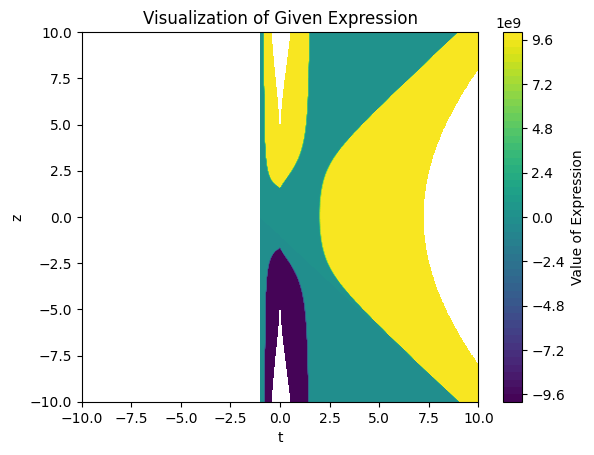


Integrated Application Menu
1: Side-by-side Diff
2: Unified Diff
3: Prevent The Silver Searcher from Searching Irrelevant Files
4: Sum Numbers
5: newj Function
6: Symbolic and Numerical Computations
7: Plot Graph
8: Interactive Visualization
9: Exit
Select an option: 7 
Do you want to handle the archeologist complex case? (yes/no): yes


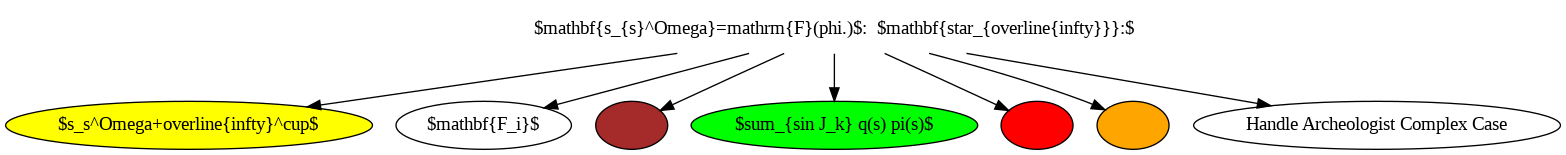

digraph CJTree {
	root [label="$\mathbf{s_{s}^\Omega}=\mathrm{F}(\phi.)$: \ $\mathbf{\star_{\overline{\infty}}}:$" shape=none]
	A [label="$s_s^\Omega+\overline{\infty}^\cup$" fillcolor=yellow shape=ellipse style=filled]
	B [label="$\mathbf{F_i}$" shape=ellipse]
	C [label="" fillcolor=brown shape=ellipse style=filled]
	D [label="$\sum_{s\in J_k} q(s) \pi(s)$" fillcolor=green shape=ellipse style=filled]
	E [label="" fillcolor=red shape=ellipse style=filled]
	F [label="" fillcolor=orange shape=ellipse style=filled]
	root -> A
	root -> B
	root -> C
	root -> D
	root -> E
	root -> F
	arch_case [label="Handle Archeologist Complex Case" shape=ellipse]
	root -> arch_case
}


Integrated Application Menu
1: Side-by-side Diff
2: Unified Diff
3: Prevent The Silver Searcher from Searching Irrelevant Files
4: Sum Numbers
5: newj Function
6: Symbolic and Numerical Computations
7: Plot Graph
8: Interactive Visualization
9: Exit
Select an option: 8


interactive(children=(FloatSlider(value=0.0, description='Time (s)', max=10.0), FloatSlider(value=5.0, descrip…


Integrated Application Menu
1: Side-by-side Diff
2: Unified Diff
3: Prevent The Silver Searcher from Searching Irrelevant Files
4: Sum Numbers
5: newj Function
6: Symbolic and Numerical Computations
7: Plot Graph
8: Interactive Visualization
9: Exit


In [ ]:
import os
import subprocess
import re
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import RegularPolygon
from graphviz import Digraph
import networkx as nx
import ipywidgets as widgets
from IPython.display import display, clear_output, Image

class IntegratedApp:

    def __init__(self):
        self.JUPDIR = os.path.expanduser('~/d/jup')

    def side_by_side_diff(self, file1, file2):
        if not os.path.exists(file1) or not os.path.exists(file2):
            print(f"One or both files do not exist: {file1}, {file2}")
            return
        try:
            diff_cmd = ["diff", "--side-by-side", file1, file2]
            subprocess.run(diff_cmd, check=True)
        except subprocess.CalledProcessError as e:
            print(f"Error executing diff command: {e}")

    def unified_diff(self, file1, file2):
        if not os.path.exists(file1) or not os.path.exists(file2):
            print(f"One or both files do not exist: {file1}, {file2}")
            return
        try:
            diff_cmd = ["diff", "-u", file1, file2]
            subprocess.run(diff_cmd, check=True)
        except subprocess.CalledProcessError as e:
            print(f"Error executing diff command: {e}")

    def prevent_silver_searcher_from_searching_irrelevant_files(self):
        try:
            ag_cmd = ["ag", "--skip-vcs-ignores"]
            subprocess.run(ag_cmd, check=True)
        except subprocess.CalledProcessError as e:
            print(f"Error executing ag command: {e}")
        except FileNotFoundError:
            print("The ag command was not found. Make sure The Silver Searcher is installed on your system.")

    def sum_numbers(self, numbers):
        return sum(numbers)

    def newj(self, option=None, param=None):
        FLGS = '--columns="-L -t -j 1e-15 -T 2.7" --header'
        logdir = 'results/archive'
        results_dir = os.path.join(self.JUPDIR, 'results')
        if not os.path.exists(results_dir):
            print(f"The directory {results_dir} does not exist. Please check the path.")
            return

        if option in ('--printheight', '-H'):
            param_dir = os.path.join(results_dir, param)
            if not os.path.isdir(param_dir):
                print(f"The directory {param_dir} does not exist. Please check the path.")
                return
            logs = [os.path.join(param_dir, f) for f in os.listdir(param_dir) if f.endswith('.log')]
            for log in logs:
                with open(log) as f:
                    content = f.read()
                    flag_match = re.search(r'\n\n;;;;;;;:', content)
                    if flag_match:
                        lines = content[:flag_match.start()].count('\n')
                        return lines
            print("mauvais printheight")
            return 1
        if not option:
            results = []
            subdirs = next(os.walk(results_dir))[1]
            for subdir in subdirs:
                result_file = os.path.join(results_dir, subdir, 'manuel.csv')
                if os.path.exists(result_file):
                    results.append(result_file)
            if not results:
                print(f"No result files found in {results_dir}")
                return
            sum_cmd = ["awk", 'BEGIN { sum = 0; for (i = 1; i < ARGC; i++) sum += ARGV[i]; print sum; }'] + results
            try:
                subprocess.run(sum_cmd, check=True)
            except subprocess.CalledProcessError as e:
                print(f"Error executing sum command: {e}")

    def symbolic_expression(self):
        t, z = sp.symbols('t z')
        x = sp.Function('x')(t)
        g, Omega, Psi = sp.symbols('g Omega Psi')

        L_Omega_Psi = sp.Function('L')(Omega, Psi)
        y_t = 1 + x

        complex_expr = (2 / t**2 / (t**2 / y_t * g)) * L_Omega_Psi
        comp_expr = ((complex_expr)**(2 * (z**2 - y_t**2 - 1))) * sp.diff((z + y_t)**2 - 1, z)

        x_t_sub = t
        comp_expr = comp_expr.subs(x, x_t_sub)

        L_value = 1
        G_value = 1
        comp_expr = comp_expr.subs([(L_Omega_Psi, L_value), (g, G_value)]).simplify()

        f_numeric = sp.lambdify((t, z), comp_expr, 'numpy')
        t_vals = np.linspace(-10, 10, 400)
        z_vals = np.linspace(-10, 10, 400)
        T, Z = np.meshgrid(t_vals, z_vals)

        with np.errstate(over='ignore', invalid='ignore'):
            F_values = f_numeric(T, Z)
            F_values = np.nan_to_num(F_values, nan=np.nan, posinf=np.nan, neginf=np.nan)

        F_values = np.clip(F_values, -1e10, 1e10)
        F_values = np.where(np.isfinite(F_values), F_values, np.nan)

        plt.contourf(T, Z, F_values, 50, cmap='viridis')
        plt.colorbar(label='Value of Expression')
        plt.title('Visualization of Given Expression')
        plt.xlabel('t')
        plt.ylabel('z')
        plt.show()

    def plot_graph(self, arch_case=False):
        dot = Digraph(name='CJTree')
        dot.node('root', r'$\mathbf{s_{s}^\Omega}=\mathrm{F}(\phi.)$: \ $\mathbf{\star_{\overline{\infty}}}:$', shape='none')

        dot.node('A', r'$s_s^\Omega+\overline{\infty}^\cup$', shape='ellipse', style='filled', fillcolor='yellow')
        dot.node('B', r'$\mathbf{F_i}$', shape='ellipse')
        dot.node('C', '', shape='ellipse', style='filled', fillcolor='brown')
        dot.node('D', r'$\sum_{s\in J_k} q(s) \pi(s)$', shape='ellipse', style='filled', fillcolor='green')
        dot.node('E', '', shape='ellipse', style='filled', fillcolor='red')
        dot.node('F', '', shape='ellipse', style='filled', fillcolor='orange')

        dot.edge('root', 'A')
        dot.edge('root', 'B')
        dot.edge('root', 'C')
        dot.edge('root', 'D')
        dot.edge('root', 'E')
        dot.edge('root', 'F')

        if arch_case:
            dot.node('arch_case', 'Handle Archeologist Complex Case', shape='ellipse')
            dot.edge('root', 'arch_case')

        dot.render('cjtree_graph', format='png')
        image_path = 'cjtree_graph.png'
        display(Image(filename=image_path))

        print(dot.source)

    def interactive_visualization(self):
        t_slider = widgets.FloatSlider(value=0, min=0, max=10, step=0.1, description="Time (s)")
        R_slider = widgets.FloatSlider(value=5, min=1, max=10, step=0.5, description="Radius (m)")
        omega_slider = widgets.FloatSlider(value=2*np.pi, min=0, max=4*np.pi, step=0.1*np.pi, description="Ang. Vel. (rad/s)")

        def update_visualization(t, R, omega):
            clear_output(wait=True)
            G = self.create_graph(omega)
            fig, (ax_tess, ax_compass) = plt.subplots(1, 2, figsize=(12, 6))

            circle = plt.Circle((0, 0), R, color='blue', fill=False, linewidth=np.abs(np.sin(omega)) + 0.5)
            ax_compass.add_artist(circle)
            x_compass = R * np.cos(omega * t)
            y_compass = R * np.sin(omega * t)
            ax_compass.plot(x_compass, y_compass, 'ro')
            ax_compass.set_aspect('equal')
            ax_compass.set_xlim(-R * 1.5, R * 1.5)
            ax_compass.set_ylim(-R * 1.5, R * 1.5)
            ax_compass.set_title("Time Compass")

            logic_vector_set = [
                (r"\left( \frac{\forall y \in \mathbb{N}, P(y) \to Q(y)}{\Delta}, \frac{\exists x \in \mathbb{N}, R(x) \wedge S(x)}{\Delta}, \frac{\forall z \in \mathbb{N}, T(z) \lor U(z)}{\Delta} \right)",),
                (r"\left( \frac{\leftrightarrow \exists y \in \mathbb{U} : f(y) = x}{\Delta}, \frac{\leftrightarrow \exists s \in S : x = T(s)}{\Delta}, \frac{\leftrightarrow x \in f \circ g}{\Delta} \right)",),
                (r"\left( \frac{\mathbb{V} \to \mathbb{U}}{\Delta}, \frac{\sum_{f \subset g} f(g)}{\Delta}, \frac{\sum_{h \to \infty} \sin t \cdot \prod_{\Lambda} h}{\Delta} \right)",),
                (r"\left( \frac{f_{PQ}(x) - f_{RS}(x)}{\Delta}, \frac{f_{TU}(x) - f_{RS}(x)}{\Delta}, \frac{f_{PQ}(x) - f_{TU}(x)}{\Delta} \right)",),
                (r"\left( \frac{\partial \phi(\mathbf{x})}{\partial x_1} a_1 + \frac{\partial \phi(\mathbf{x})}{\partial x_2} a_2 + \cdots + \frac{\partial \phi(\mathbf{x})}{\partial x_n} a_n \right)",),
                (r"\left( \frac{\phi(\mathbf{x}) \leq \psi(\mathbf{x})}{\Delta}, \frac{\phi(\mathbf{x}) \geq \psi(\mathbf{x})}{\Delta}, \frac{\phi(\mathbf{x}) = \psi(\mathbf{x})}{\Delta} \right)",)
            ]

            pos = nx.spring_layout(G, iterations=50)
            nx.draw(G, pos=pos, ax=ax_tess)
            ax_tess.set_title("Directed graph affected by Omega")
            ax_tess.axis('off')

            def interpret_logic_vector(logic_vector, theta):
                applied_functions = []
                for component in logic_vector:
                    if 'forall' in component:
                        applied_functions.append(lambda x: np.prod([component.count('forall') for _ in range(int(theta))]))
                    elif 'exists' in component:
                        applied_functions.append(lambda x: np.sum([component.count('exists') for _ in range(int(theta))]))
                    elif 'sin' in component:
                        applied_functions.append(lambda x: np.sin(component.count('sin') * theta))
                    elif 'cos' in component:
                        applied_functions.append(lambda x: np.cos(component.count('cos') * theta))
                    else:
                        applied_functions.append(lambda x: x)
                combined_function = lambda x: sum([f(x) for f in applied_functions])
                return combined_function(theta)

            domain = (-5, 5, -5, 5)
            hex_size = 0.5
            hex_centers = [(i, j) for i in np.arange(domain[0], domain[1], hex_size) for j in np.arange(domain[2], domain[3], hex_size)]

            for i, center in enumerate(hex_centers):
                x, y = center
                theta = np.arctan2(y, x) if x != 0 else np.pi / 2
                logic_function = interpret_logic_vector(logic_vector_set[i % len(logic_vector_set)], theta)
                efficiency_value = np.abs(np.sin(omega * t)) * np.abs(np.cos(omega * t)) * logic_function
                color_value = np.clip(efficiency_value, 0, 1)

                hexagon = RegularPolygon((x, y), numVertices=6, radius=hex_size, orientation=np.pi / 6)
                hexagon.set_facecolor(plt.cm.hsv(color_value))
                ax_tess.add_patch(hexagon)

            display(fig)

        widgets.interact(update_visualization, t=t_slider, R=R_slider, omega=omega_slider)

    def create_graph(self, omega_value):
        G = nx.DiGraph()
        num_nodes = int(4 + np.abs(np.sin(omega_value)) * 10)
        for i in range(num_nodes):
            G.add_node(i)
            if i != 0:
                G.add_edge(0, i)
        return G

# Instantiate the integrated application
app = IntegratedApp()

# Add a menu interface
def menu_interface():
    options = {
        1: 'Side-by-side Diff',
        2: 'Unified Diff',
        3: 'Prevent The Silver Searcher from Searching Irrelevant Files',
        4: 'Sum Numbers',
        5: 'newj Function',
        6: 'Symbolic and Numerical Computations',
        7: 'Plot Graph',
        8: 'Interactive Visualization',
        9: 'Exit'
    }

    while True:
        print("\nIntegrated Application Menu")
        for key, value in options.items():
            print(f"{key}: {value}")

        choice = int(input("Select an option: "))

        if choice == 1:
            file1 = input("Enter the first file path: ")
            file2 = input("Enter the second file path: ")
            app.side_by_side_diff(file1, file2)
        elif choice == 2:
            file1 = input("Enter the first file path: ")
            file2 = input("Enter the second file path: ")
            app.unified_diff(file1, file2)
        elif choice == 3:
            app.prevent_silver_searcher_from_searching_irrelevant_files()
        elif choice == 4:
            numbers = list(map(int, input("Enter numbers separated by space: ").split()))
            result = app.sum_numbers(numbers)
            print(f"Sum: {result}")
        elif choice == 5:
            option = input("Enter the option (or leave empty for default): ")
            param = input("Enter the param (or leave empty for default): ")
            app.newj(option, param)
        elif choice == 6:
            app.symbolic_expression()
        elif choice == 7:
            arch_case = input("Do you want to handle the archeologist complex case? (yes/no): ").strip().lower() == 'yes'
            app.plot_graph(arch_case)
        elif choice == 8:
            app.interactive_visualization()
        elif choice == 9:
            break
        else:
            print("Invalid option. Please try again.")

# Start the menu interface
menu_interface()